# Phase 4 Project

## Time Series Model

Let us start by loading the datasets and see what type of data we are dealing with

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

Let's load US energy generation

In [3]:
df = pd.read_csv('organised_Gen.csv',
                 parse_dates={ 'date': ['YEAR', 'MONTH'] })
df

date  Unnamed: 0 STATE                         TYPE OF PRODUCER  \
0      2001-01-01           0    AK            Total Electric Power Industry   
1      2001-01-01           1    AK            Total Electric Power Industry   
2      2001-01-01           2    AK            Total Electric Power Industry   
3      2001-01-01           3    AK            Total Electric Power Industry   
4      2001-01-01           4    AK            Total Electric Power Industry   
...           ...         ...   ...                                      ...   
496769 2022-05-01       10581    WY  Electric Generators, Electric Utilities   
496770 2022-05-01       10582    WY  Electric Generators, Electric Utilities   
496771 2022-05-01       10583    WY  Electric Generators, Electric Utilities   
496772 2022-05-01       10584    WY  Electric Generators, Electric Utilities   
496773 2022-05-01       10585    WY  Electric Generators, Electric Utilities   

                     ENERGY SOURCE  GENERATION (Megawatthours)  
0                             Coal                     46903.0  
1                        Petroleum                     71085.0  
2                      Natural Gas                    367521.0  
3       Hydroelectric Conventional                    104549.0  
4                             Wind                        87.0  
...                            ...                         ...  
496769                        Coal                   2071403.0  
496770  Hydroelectric Conventional                     96790.0  
496771                 Natural Gas                     91570.0  
496772                   Petroleum                      1812.0  
496773                        Wind                    452913.0  

[496774 rows x 6 columns]

In [4]:
df.set_index('date', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

STATE                         TYPE OF PRODUCER  \
date                                                        
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
...          ...                                      ...   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   

                         ENERGY SOURCE  GENERATION (Megawatthours)  
date                                                                
2001-01-01                        Coal                     46903.0  
2001-01-01                   Petroleum                     71085.0  
2001-01-01                 Natural Gas                    367521.0  
2001-01-01  Hydroelectric Conventional                    104549.0  
2001-01-01                        Wind                        87.0  
...                                ...                         ...  
2022-05-01                        Coal                   2071403.0  
2022-05-01  Hydroelectric Conventional                     96790.0  
2022-05-01                 Natural Gas                     91570.0  
2022-05-01                   Petroleum                      1812.0  
2022-05-01                        Wind                    452913.0  

[496774 rows x 4 columns]

In [8]:
df.isna().sum()

STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64

In [5]:
df.describe()

GENERATION (Megawatthours)
count                4.967740e+05
mean                 1.393384e+06
std                  1.078685e+07
min                 -9.978550e+05
25%                  1.643000e+03
50%                  2.330103e+04
75%                  2.792042e+05
max                  4.217967e+08

Very interesting! Could pick a couple of energy sources and analyze them in parallel

In [4]:
df['ENERGY SOURCE'].value_counts()

Total                             73356
Natural Gas                       66684
Petroleum                         63176
Coal                              47642
Other Biomass                     46148
Hydroelectric Conventional        38842
Other                             36241
Wood and Wood Derived Fuels       30524
Wind                              25421
Solar Thermal and Photovoltaic    19393
Other Gases                       18212
Nuclear                           16754
Pumped Storage                    10139
Geothermal                         4242
Name: ENERGY SOURCE, dtype: int64

In [24]:
US_total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=US_total.loc[US_total['STATE']=='US-TOTAL']

In [25]:
US_total

STATE               TYPE OF PRODUCER  \
date                                                  
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
...              ...                            ...   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   

                             ENERGY SOURCE  GENERATION (Megawatthours)  
date                                                                    
2001-01-01                            Coal                 177287111.0  
2001-01-01                       Petroleum                  18111843.0  
2001-01-01                     Natural Gas                  42388663.0  
2001-01-01                     Other Gases                    718442.0  
2001-01-01                         Nuclear                  68707077.0  
...                                    ...                         ...  
2022-05-01                       Petroleum                   1524488.0  
2022-05-01  Solar Thermal and Photovoltaic                  15151118.0  
2022-05-01                   Other Biomass                   1440366.0  
2022-05-01                            Wind                  41891907.0  
2022-05-01     Wood and Wood Derived Fuels                   3073482.0  

[3598 rows x 4 columns]

In [26]:
US_total['ENERGY SOURCE'].value_counts()

Wood and Wood Derived Fuels       257
Nuclear                           257
Geothermal                        257
Petroleum                         257
Coal                              257
Other Gases                       257
Other                             257
Hydroelectric Conventional        257
Other Biomass                     257
Natural Gas                       257
Total                             257
Solar Thermal and Photovoltaic    257
Wind                              257
Pumped Storage                    257
Name: ENERGY SOURCE, dtype: int64

#### Changing Scale
GIven the high values for the column 'Generation (Megawatthours)' once we take the totals, we will convert the units to Terawatts per hour, where TWh=MWh*10^6.

In [27]:
US_total["Generation (TWh)"]=US_total["GENERATION (Megawatthours)"]/1000000
US_total.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
US_total

STATE               TYPE OF PRODUCER  \
date                                                  
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
...              ...                            ...   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   

                             ENERGY SOURCE  Generation (TWh)  
date                                                          
2001-01-01                            Coal        177.287111  
2001-01-01                       Petroleum         18.111843  
2001-01-01                     Natural Gas         42.388663  
2001-01-01                     Other Gases          0.718442  
2001-01-01                         Nuclear         68.707077  
...                                    ...               ...  
2022-05-01                       Petroleum          1.524488  
2022-05-01  Solar Thermal and Photovoltaic         15.151118  
2022-05-01                   Other Biomass          1.440366  
2022-05-01                            Wind         41.891907  
2022-05-01     Wood and Wood Derived Fuels          3.073482  

[3598 rows x 4 columns]

In [28]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [29]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

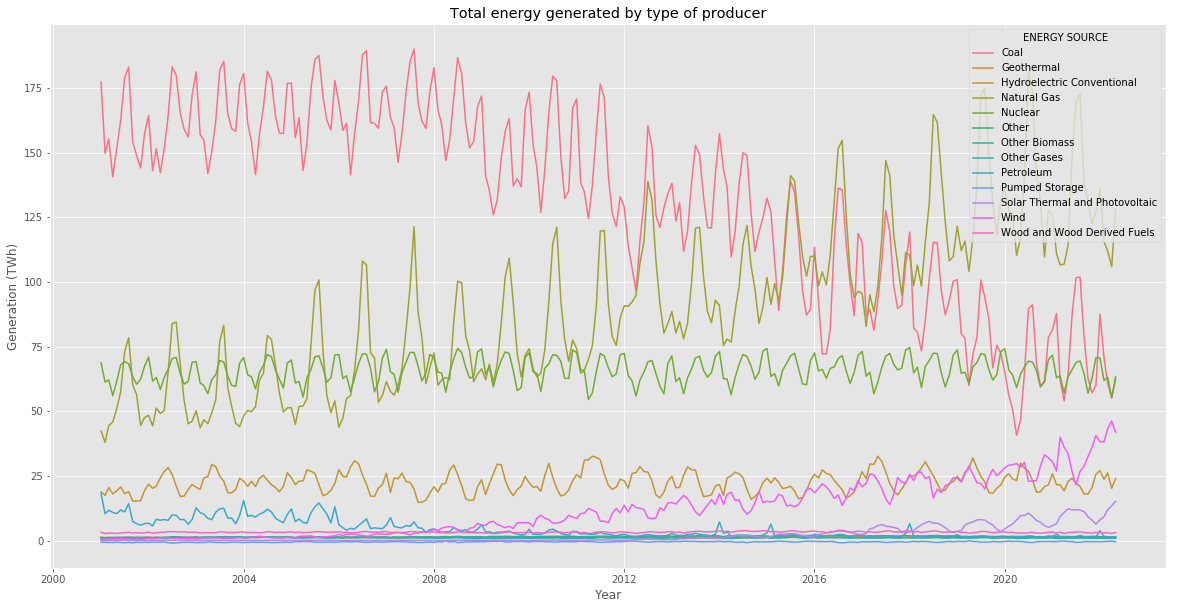

In [30]:
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=US_source, x=US_source['date'] ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
#Plot additional properties
#plt.grid()
#plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


Let us divide up the energy sources to be able to better see form the graphs their trends.

In [31]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [32]:
US_top3

date ENERGY SOURCE  Generation (TWh)
0    2001-01-01          Coal        177.287111
3    2001-01-01   Natural Gas         42.388663
4    2001-01-01       Nuclear         68.707077
14   2001-02-01          Coal        149.735484
17   2001-02-01   Natural Gas         37.966927
...         ...           ...               ...
3573 2022-04-01   Natural Gas        105.934050
3574 2022-04-01       Nuclear         55.289540
3584 2022-05-01          Coal         62.288238
3587 2022-05-01   Natural Gas        127.926186
3588 2022-05-01       Nuclear         63.381624

[771 rows x 3 columns]

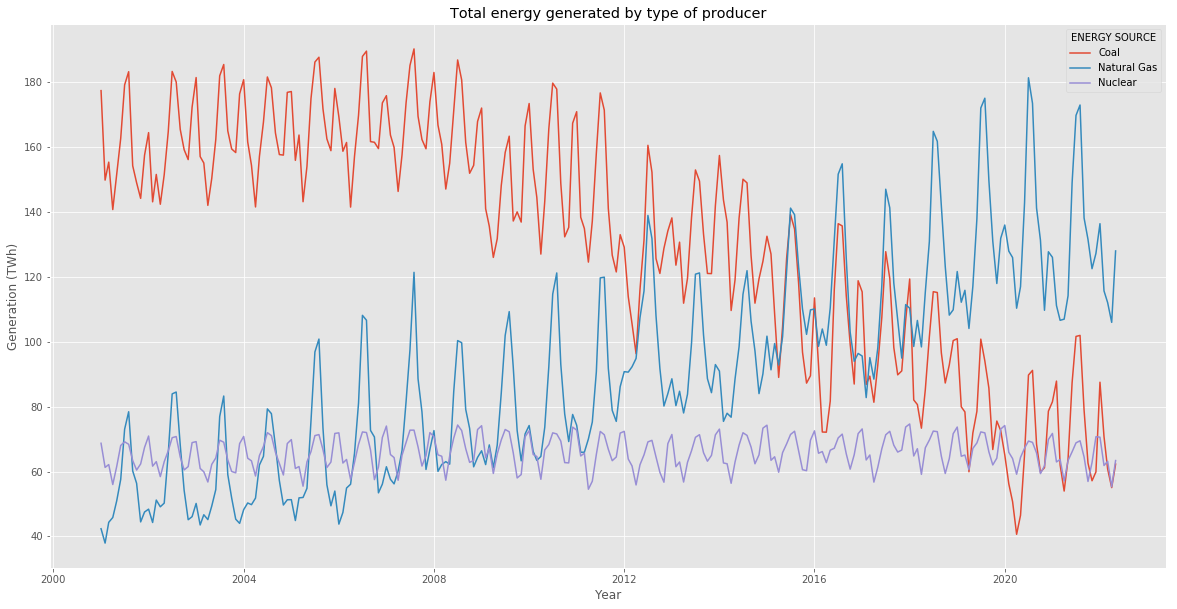

In [33]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['date'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


In [34]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

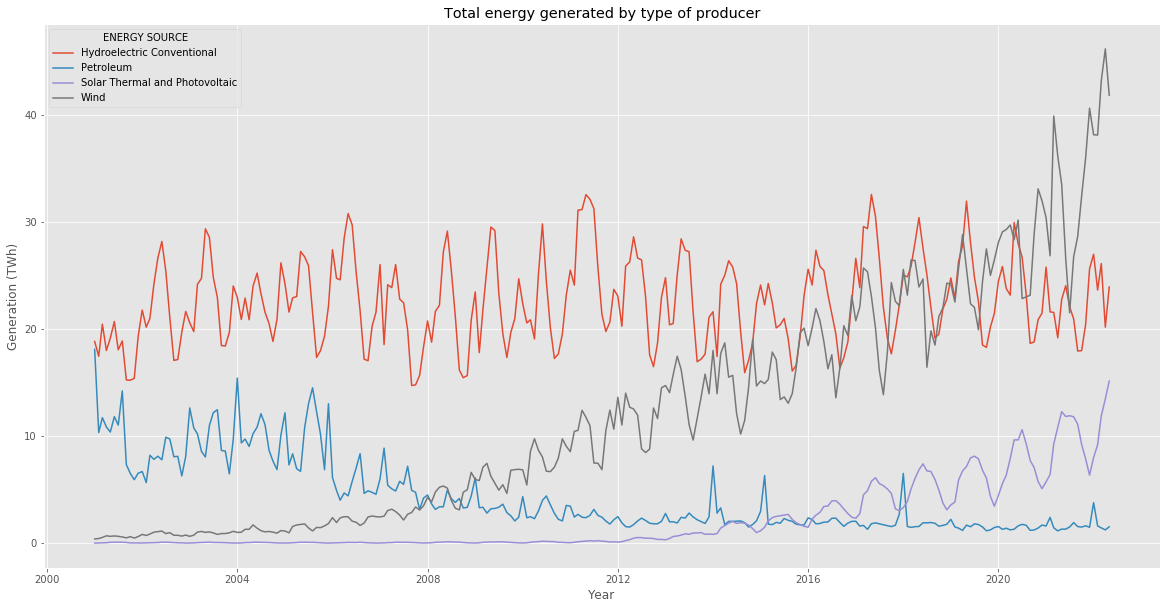

In [258]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['date'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

In [36]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

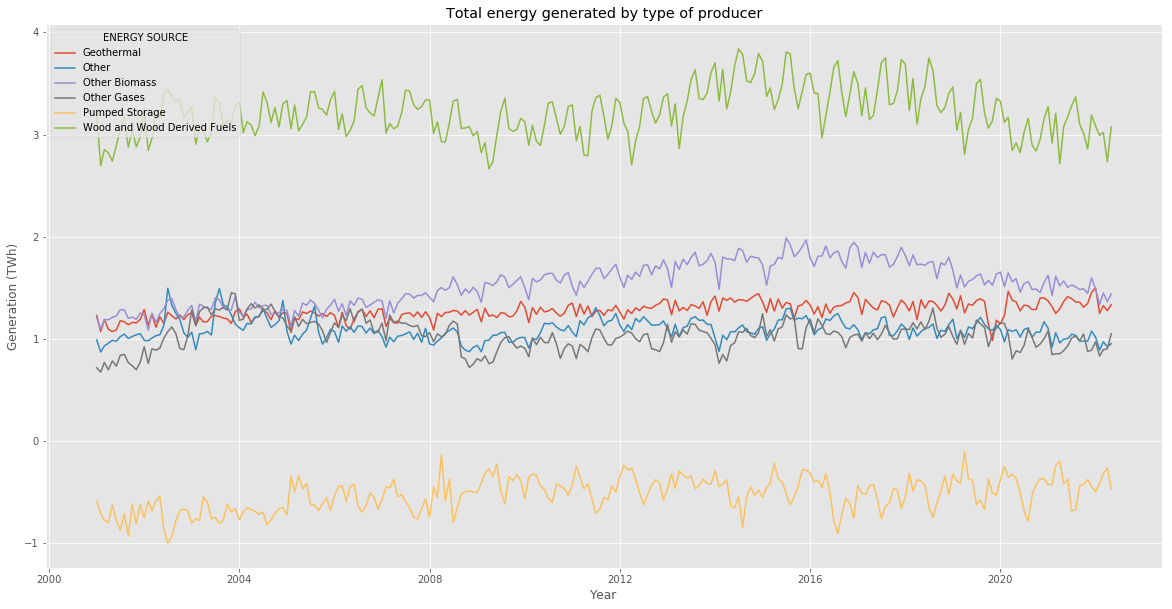

In [37]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_bot, x=US_bot['date'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

The trends that have shown to be more interesting, with an upward trend over time are:
 Natural Gas, Wind and Solar. So let us preview those.

> improve these graphs

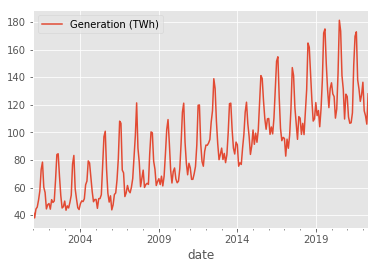

In [41]:
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
US_nat.plot();

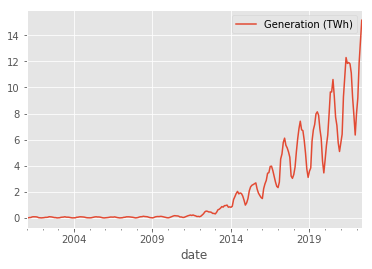

In [42]:
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
US_sol.plot();

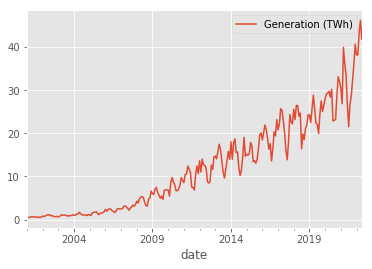

In [43]:
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
US_wind.plot();

> Maybe here could add also histogram or density plot

### Subtracting Rolling Mean

In [259]:
roll_mean = US_nat.rolling(window=12, center=False).mean()
roll_std = US_nat.rolling(window=12, center=False).std()

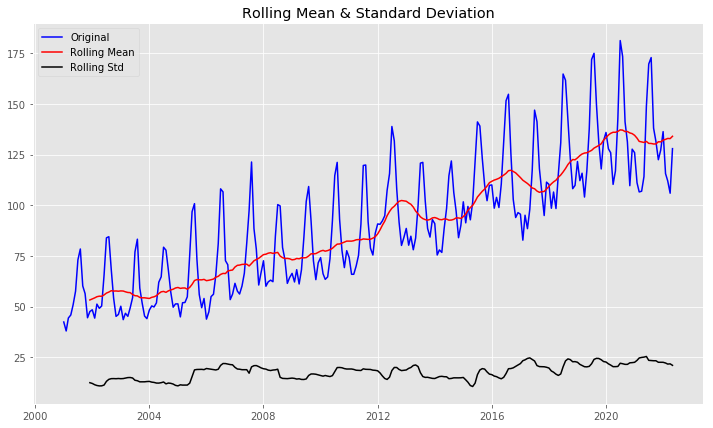

In [260]:
fig = plt.figure(figsize=(12,7))
plt.plot(US_nat['Generation (TWh)'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [46]:
dftest = adfuller(US_nat['Generation (TWh)'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-0.37362259172173906, 0.9144105810373786, 14, 242, {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}, 1577.17119640526)


In [47]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -0.373623
p-value                          0.914411
#Lags Used                      14.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


The p values is clearly > 0.05, the series is not stationary as we could expect.

In [48]:
wind=US_wind['Generation (TWh)']
nat=US_nat['Generation (TWh)']
sol=US_sol['Generation (TWh)']
#coal=US_coal['Generation (TWh)']
#oil=US_oil['Generation (TWh)']

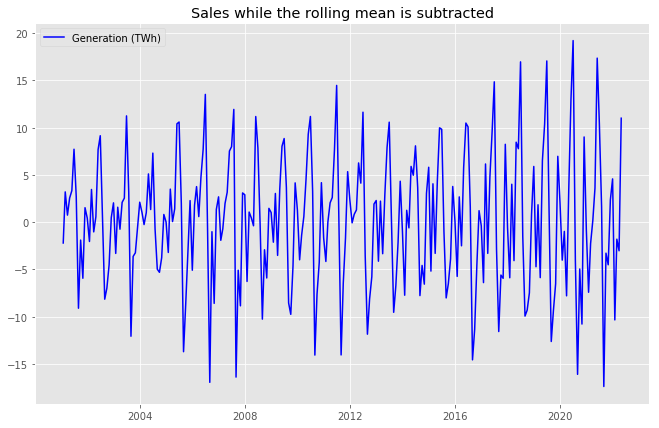

In [262]:
roll_mean_nat = US_nat['Generation (TWh)'].rolling(window=2, center=False).mean()
# Subtract the moving average from the original data
data_mrm_nat = nat - roll_mean_nat
# Drop the missing values from time series calculated above
data_mrm_nat.dropna(inplace=True)
# Plot sales with rolling mean subtracted
fig = plt.figure(figsize=(11,7))
plt.plot(data_mrm_nat, color='blue')#,label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show();#(block=False)

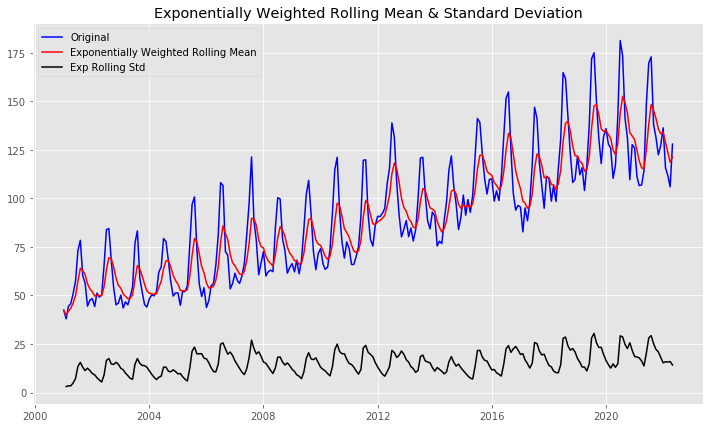

In [263]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = nat.ewm(halflife=2).mean()
roll_std = nat.ewm(halflife=2).std()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(nat, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.plot(roll_std, color='black', label = 'Exp Rolling Std')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

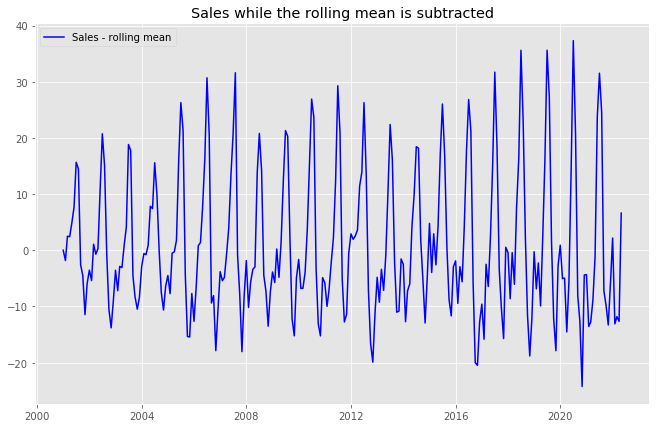

In [264]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = nat - exp_roll_mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [265]:
dftest = adfuller(data_mrm_nat)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.136855
p-value                          0.000841
#Lags Used                      13.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


In [53]:
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.995365
p-value                          0.000023
#Lags Used                      15.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


> Here maybe a paragraph in which you explain what it means, the fact that the residualas are stationary and why do we subract the rolling mean, because there is a dependence on the previous periods, specifically the amounts of periods specified in the window. And that expotential means the ones closer in time are more relevant then the others.

## Series Decomposition

**When log is better than natural, is because the trend is exponential (growth in our case) inste of linear growth.**

### Decomposing Natural Gas

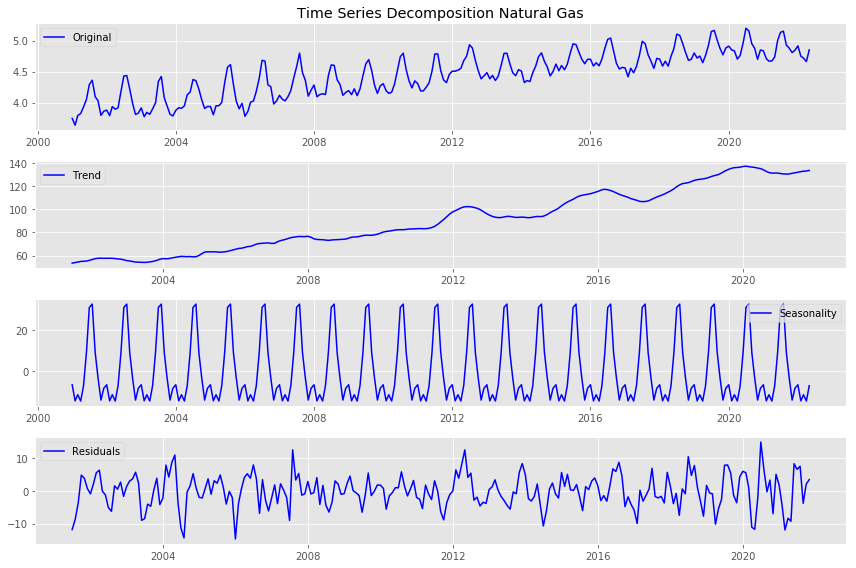

In [57]:
decomposition = seasonal_decompose(nat)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(nat), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [58]:
residual.dropna(inplace=True)

In [59]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -9.881169e+00
p-value                        3.766672e-17
#Lags Used                     8.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


### Decomposing log(natural gas)

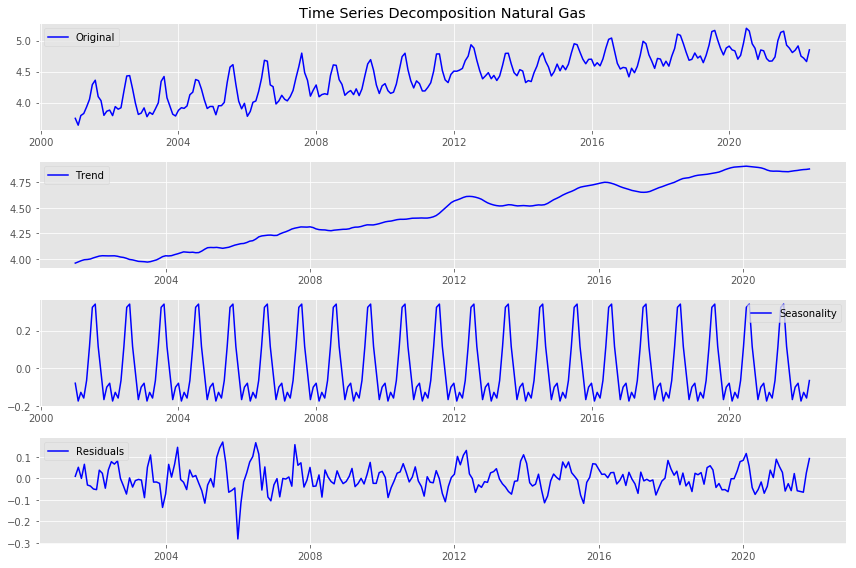

In [60]:
decomposition = seasonal_decompose(np.log(nat))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(nat), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [61]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -9.729587e+00
p-value                        9.079601e-17
#Lags Used                     8.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


### Decomposing Solar

In [ ]:
decomposition = seasonal_decompose(sol)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

### Decomposing log(Solar)

In [ ]:
decomposition = seasonal_decompose(np.log(sol))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

It seems like something else is going on with solar.
I want to see if the decomposition will work better once I cut out the part that was basically zero.

In [ ]:
US_sol.describe()

In [ ]:
US_sol.plot();

In [ ]:
sol2011=US_sol['2011':]

In [ ]:
sol2011.plot();

In [ ]:
sol2012=US_sol['2012':]
sol2012.plot();


In [ ]:
sol11=sol2011['Generation (TWh)']
sol12=sol2012['Generation (TWh)']

### Decomposing solar after 2011

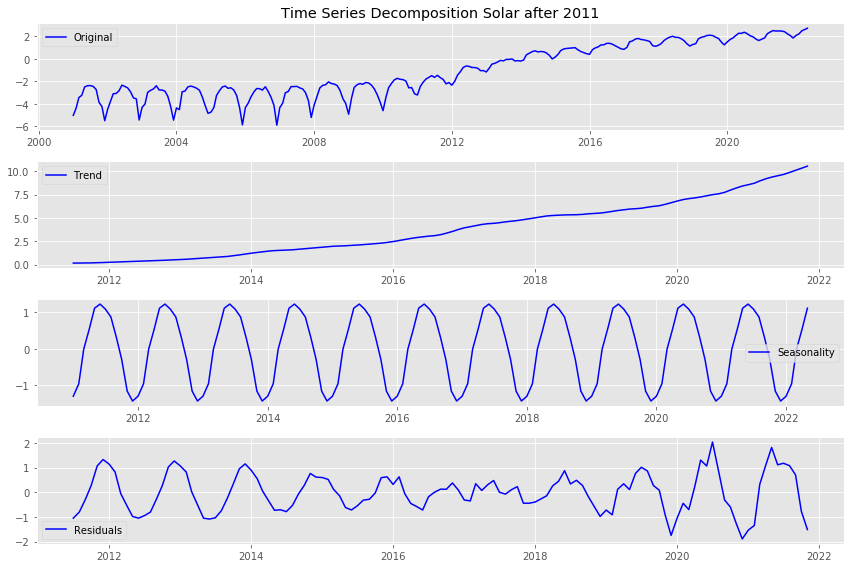

In [79]:
decomposition = seasonal_decompose(sol11)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar after 2011')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [80]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.089199e+00
p-value                        1.046385e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


### Log

In [81]:
decomposition = seasonal_decompose(np.log(sol11))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.037527e+00
p-value                        1.370680e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64


### Solar after 2012

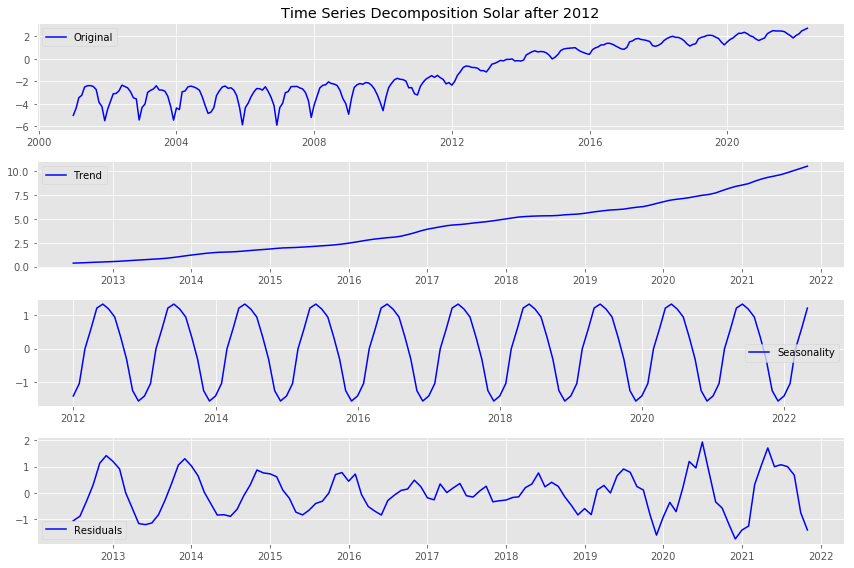

In [82]:
decomposition = seasonal_decompose(sol12)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar after 2012')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [83]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -5.880925e+00
p-value                        3.079799e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64


### Log

In [84]:
decomposition = seasonal_decompose(np.log(sol12))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -5.763087e+00
p-value                        5.613159e-07
#Lags Used                     7.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64


### Decomposing Wind

In [ ]:
decomposition = seasonal_decompose((wind))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(Wind)')
plt.plot(np.log(wind), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

### Decomposing log(wind)

In [ ]:
decomposition = seasonal_decompose(np.log(wind))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Wind')
plt.plot(np.log(wind), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

## Multiplicative instead of additive models

Not getting better. Let's try multiplicative instead of additive. Back to the whole series, which performed better.

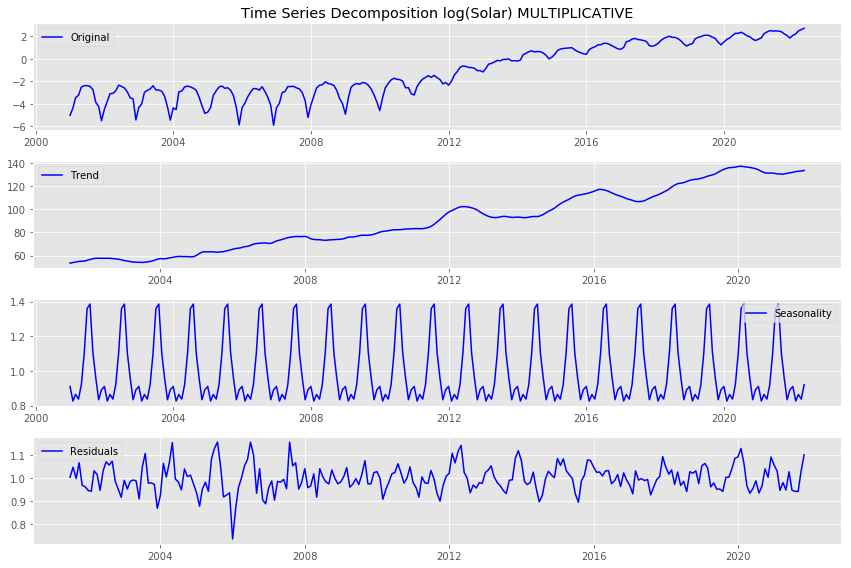

In [278]:
decomposition = seasonal_decompose(nat, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(Solar) MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [279]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.495130e+00
p-value                        1.199565e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


Much better!
Now out of curiosity let me try to do multiplicative for the other resources too and see if the residulas improve.

Results of Dickey-Fuller test: 

Test Statistic                  -1.261344
p-value                          0.646667
#Lags Used                      12.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


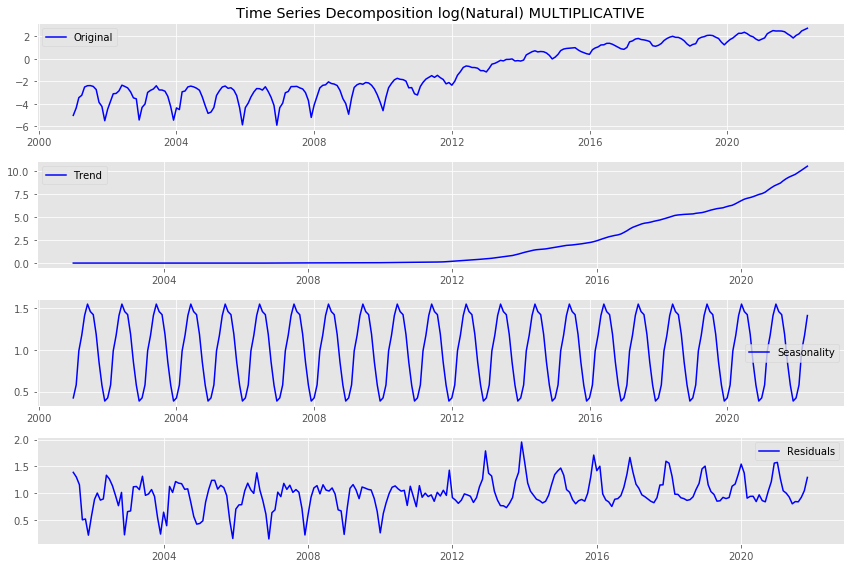

In [280]:
decomposition = seasonal_decompose(sol, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(Natural) MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.168402e+00
p-value                        8.755891e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


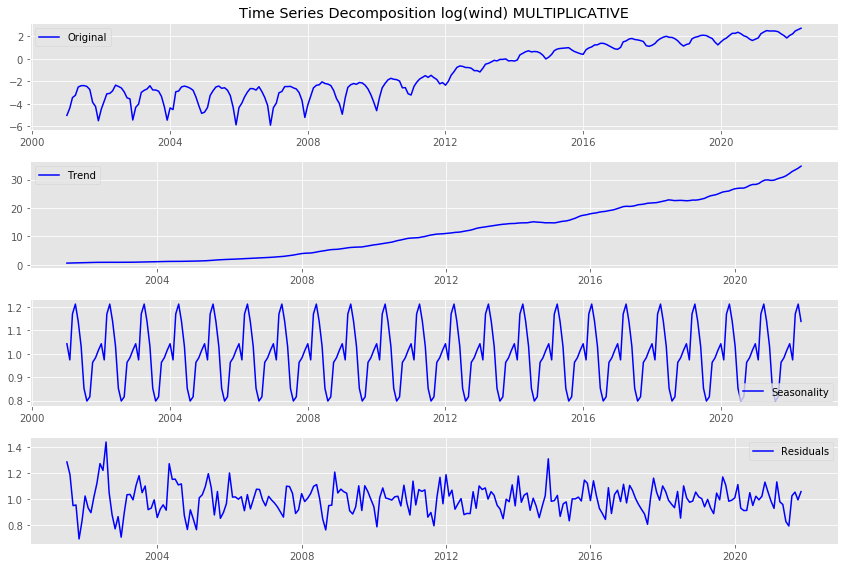

In [281]:
decomposition = seasonal_decompose(wind, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(wind) MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Still unclear if it is multiplicative or no for wind and natural gas, since it is basically the same.
For solar though there seems to be a great improvement with the multiplicative model at least in the scale of the residuals.
But need to stuyd it more because if I do multiplicative non log for some reason it gets worse.

### Multiplicative natural instead of log
### I HAD TO CHANGE THE LOG THAT WAS RIGHT BEFORE
this because it wasn't working for some negative values. Changed all to natural instead of log. Can go back adn reverse it and take care of null values but see if it makes sense.

Results of Dickey-Fuller test: 

Test Statistic                  -1.261344
p-value                          0.646667
#Lags Used                      12.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


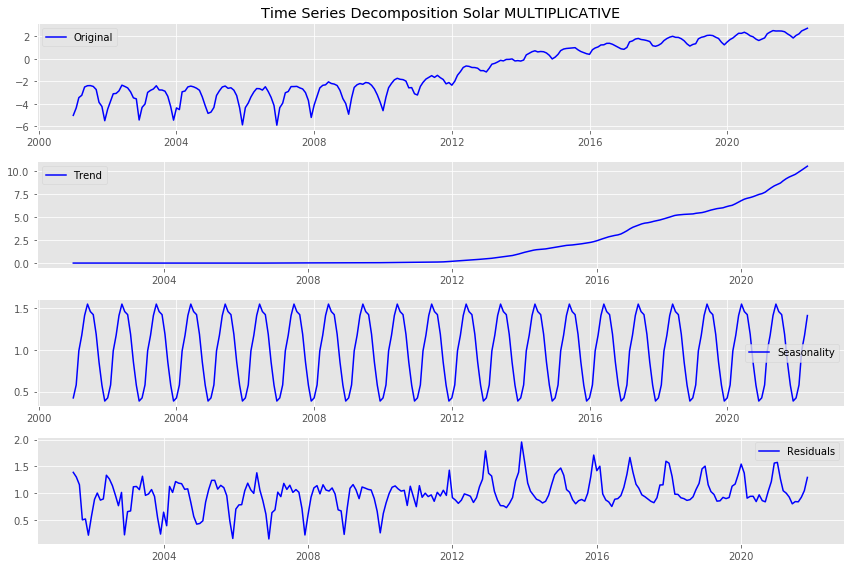

In [89]:
decomposition = seasonal_decompose(nat, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.495130e+00
p-value                        1.199565e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


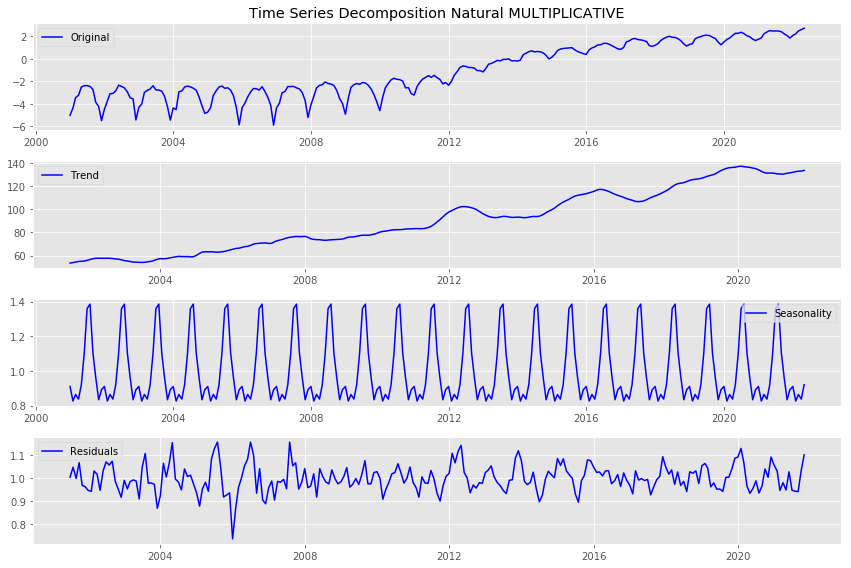

In [90]:
decomposition = seasonal_decompose(sol, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.168402e+00
p-value                        8.755891e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


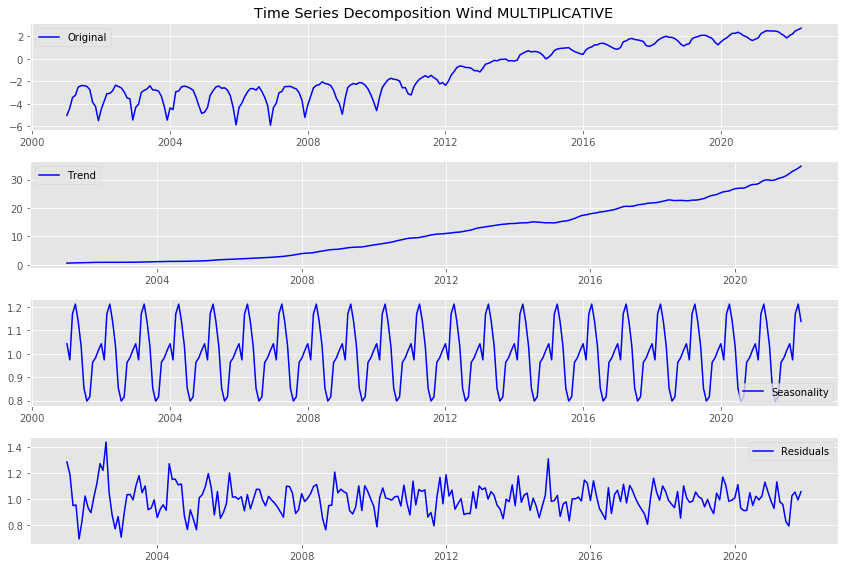

In [91]:
decomposition = seasonal_decompose(wind, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Wind MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Wind and Natural Gas, non log are ok. Solar no.

### BUT
solar eve if it is lower then p result with multiplicative, it still performs better with additive. It's just a bit weird that the residuals are SO HIGH with additive, and yet the dickey fuller test has better results then the much lower scale residulas of the multiplicative model.
> Goot look into this later and figure out.

## Studying Autocorrelation

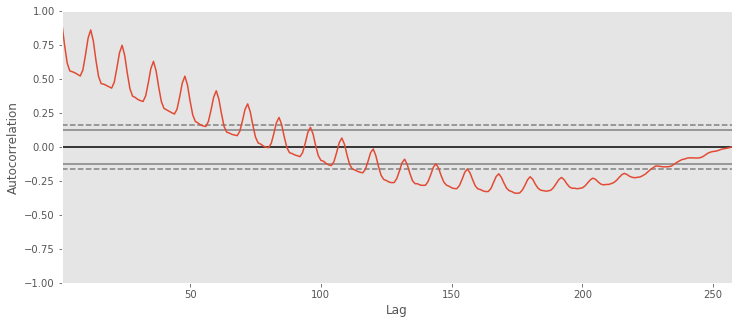

In [282]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat);

In [ ]:
nat_diff = nat.diff(periods=1)
nat_diff.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff, color='b');

In [ ]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(sol);

In [ ]:
sol_diff = sol.diff(periods=1)
sol_diff.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(sol_diff, color='b');

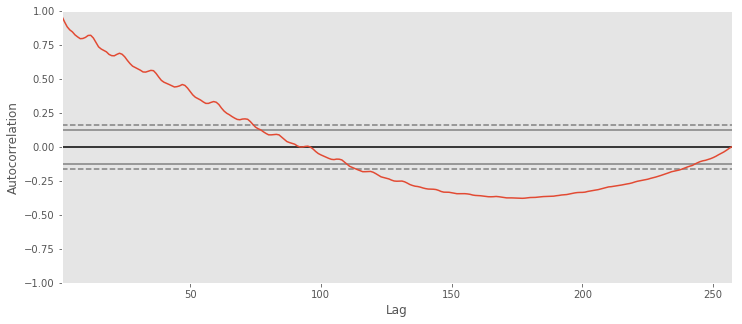

In [92]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(wind);

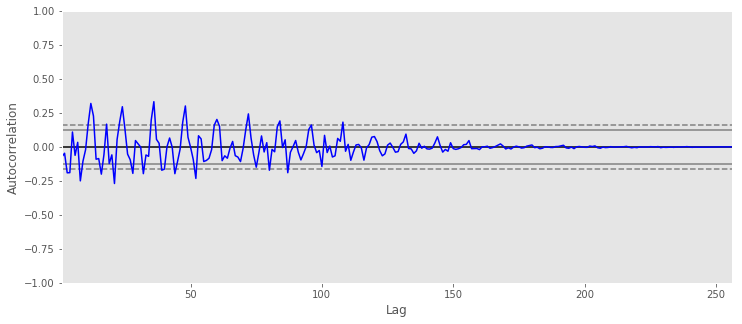

In [93]:
wind_diff = wind.diff(periods=1)
wind_diff.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(wind_diff, color='b');

## PACF

### Natural Gas

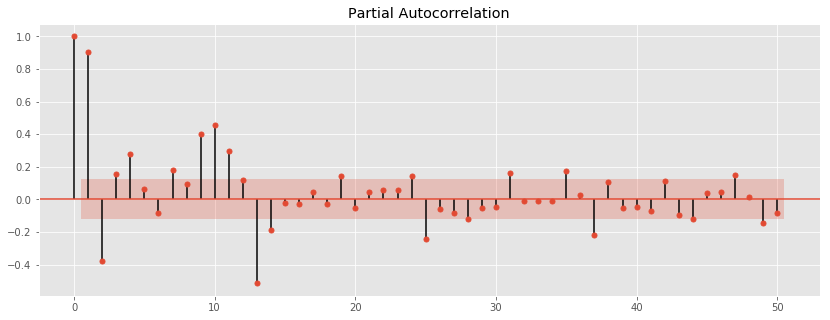

In [283]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat, lags=50);

### Solar

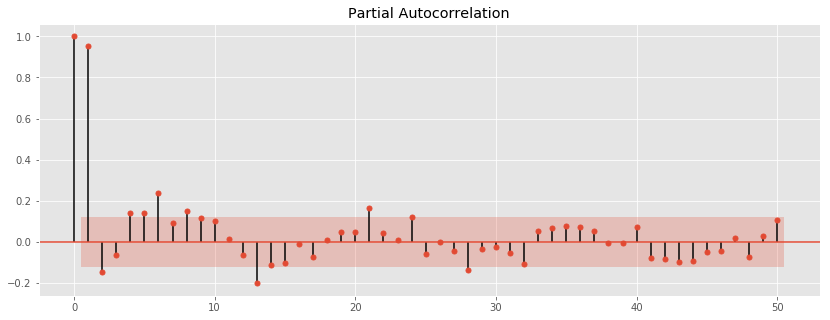

In [284]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(sol, lags=50);

### Wind

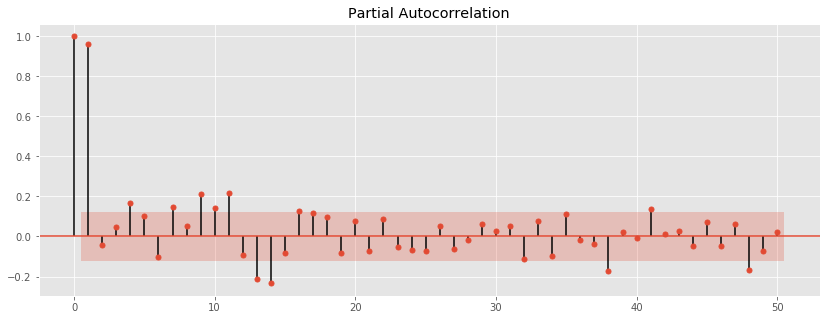

In [100]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(wind, lags=50);

## ACF

### Natural Gas

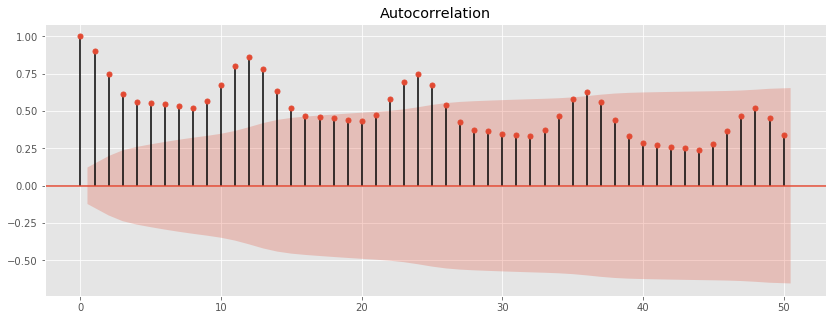

In [285]:
rcParams['figure.figsize'] = 14, 5

plot_acf(nat, lags=50);

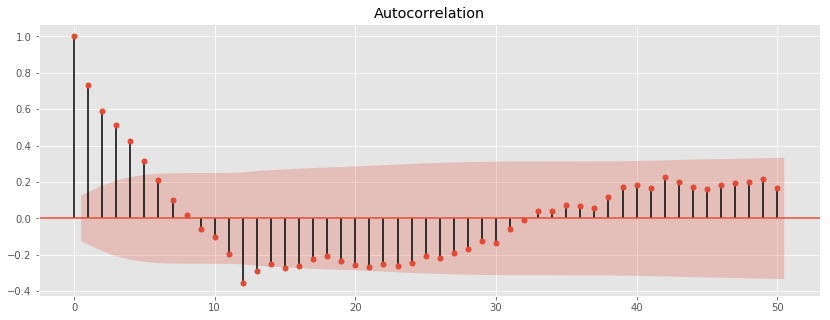

In [286]:
rcParams['figure.figsize'] = 14, 5

plot_acf(nat_diff, lags=50);

### Solar

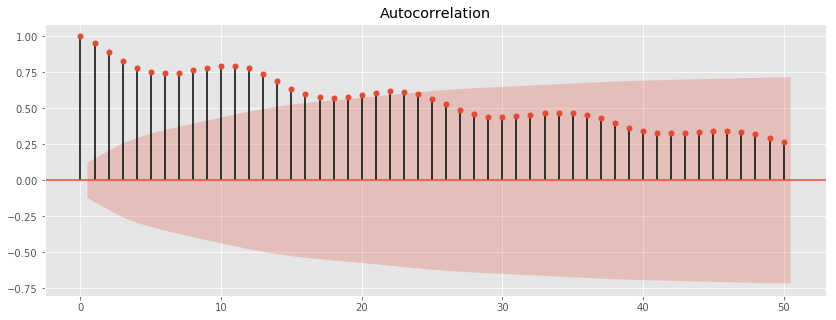

In [101]:

rcParams['figure.figsize'] = 14, 5

plot_acf(sol, lags=50);

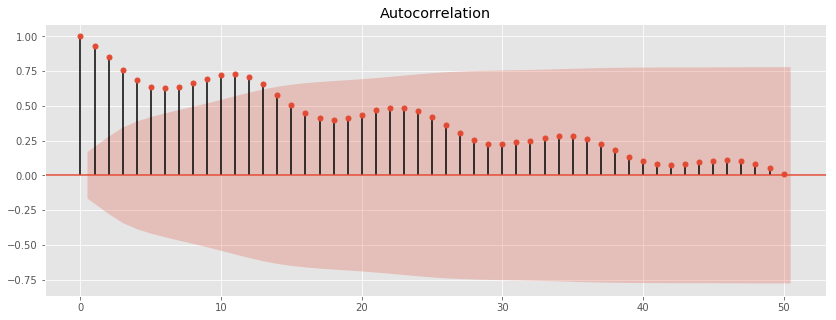

In [102]:

rcParams['figure.figsize'] = 14, 5

plot_acf(sol11, lags=50);

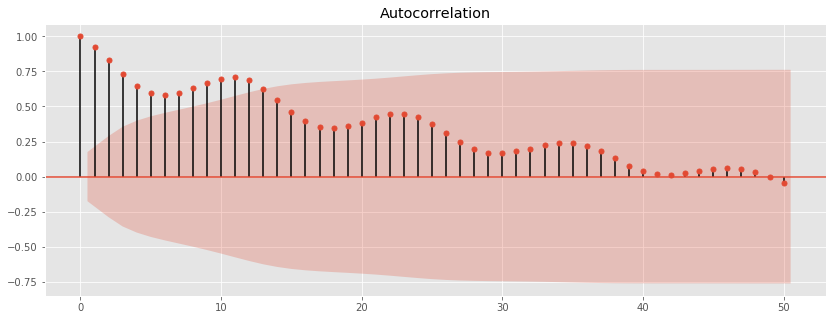

In [103]:

rcParams['figure.figsize'] = 14, 5

plot_acf(sol12, lags=50);

### Wind

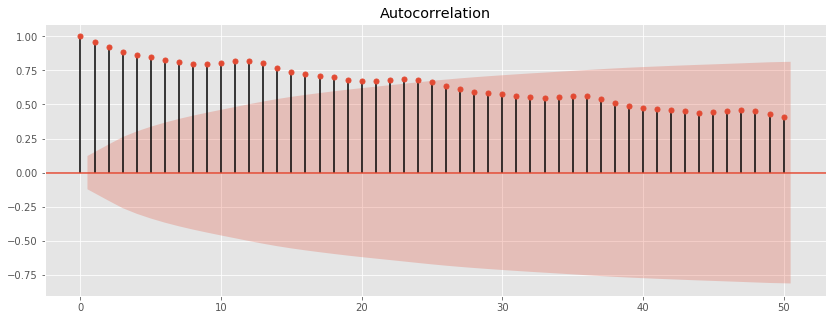

In [106]:

rcParams['figure.figsize'] = 14, 5

plot_acf(wind, lags=50);

### PACF with first difference

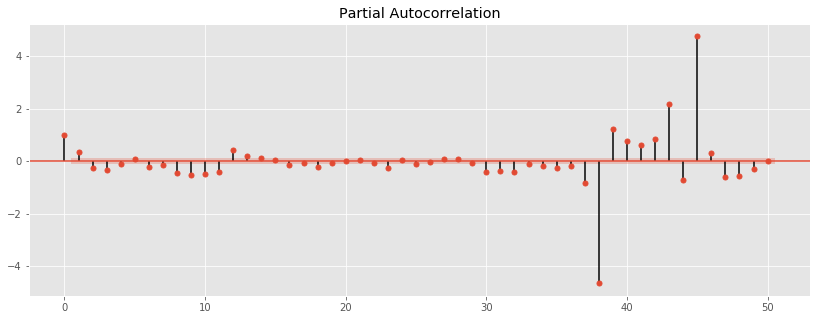

In [109]:
nat_diff = nat.diff(periods=1)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

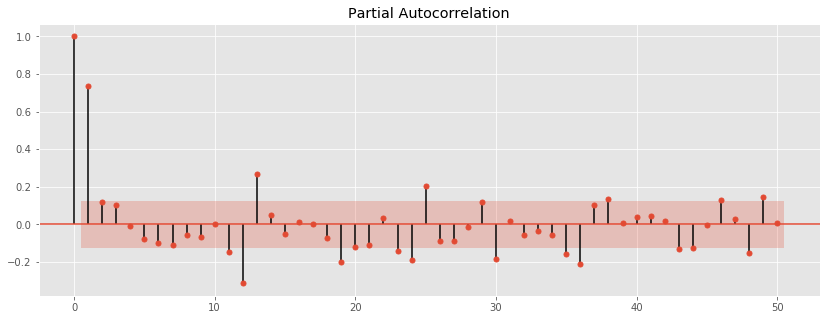

In [110]:
nat_diff = nat.diff(periods=12)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

> look into this, why with periods = 12 the pacf makes much mores sense

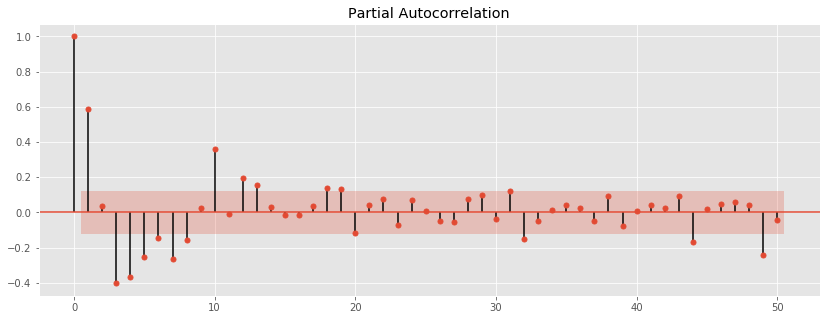

In [111]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(sol_diff, lags=50);

In [ ]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(wind_diff, lags=50);

> also: why does the PACF make more sense with the differenced 1 time series? Try to understand this.

> another idea create a DF with one column per source and then see if there is correlation between them
> the correlation can be seen with df.corr( ) and I can also do it on the series that are differenced

From here on we will dig deeper into natural gas as it is higher in production and is a more stable source of energy since it does not depend on uncontrollable factors like weather, which is the case for solar and wind.
We might go back to solar and wind after finished with Natural if there is time.

## ARMA models

### Natural Gas

In [112]:
mod_arma = ARIMA(nat, order=(1,0,0))

In [113]:
# Fit the model to data
res_arma = mod_arma.fit()

In [114]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1028.154
Date:                Fri, 10 Mar 2023   AIC                           2062.308
Time:                        15:33:28   BIC                           2072.955
Sample:                    01-01-2001   HQIC                          2066.589
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.2413      9.596      9.404      0.000      71.433     109.049
ar.L1          0.9127      0.026     34.552      0.000       0.861       0.964
sigma2       173.5493     14.798     11.728      0.0

In [115]:
# Print out the estimate for the constant and for theta
print(res_arma.params)

const      90.241348
ar.L1       0.912702
sigma2    173.549339
dtype: float64


In [116]:
mod_arma = ARIMA(nat, order=(1,1,0))

In [117]:
# Fit the model to data
res_arma = mod_arma.fit()

In [118]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1013.644
Date:                Fri, 10 Mar 2023   AIC                           2031.289
Time:                        15:33:28   BIC                           2038.379
Sample:                    01-01-2001   HQIC                          2034.141
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3350      0.060      5.606      0.000       0.218       0.452
sigma2       160.8914     13.564     11.862      0.000     134.307     187.476
Ljung-Box (L1) (Q):                   2.07   Jarque-

In [119]:
mod_arma = ARIMA(nat, order=(1,1,1))

In [120]:
# Fit the model to data
res_arma = mod_arma.fit()

In [121]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1010.312
Date:                Fri, 10 Mar 2023   AIC                           2026.624
Time:                        15:33:28   BIC                           2037.259
Sample:                    01-01-2001   HQIC                          2030.901
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1074      0.148      0.724      0.469      -0.183       0.398
ma.L1          0.2865      0.140      2.053      0.040       0.013       0.560
sigma2       156.7308     13.750     11.398      0.0

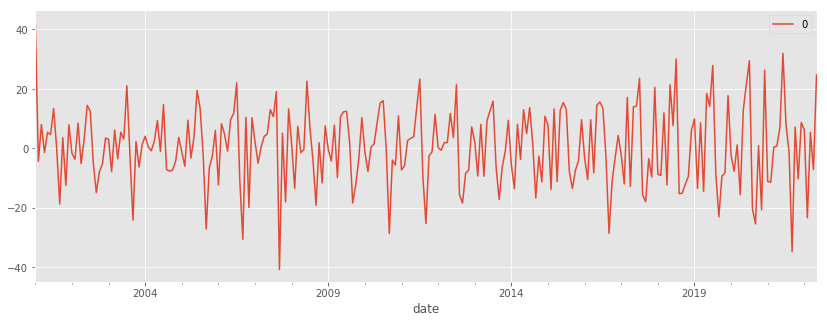

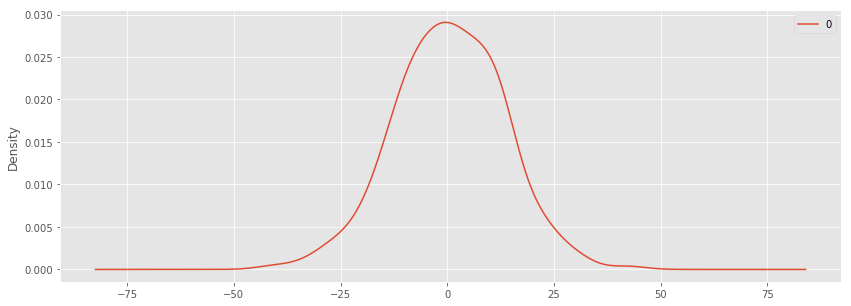

                0
count  257.000000
mean     0.423959
std     12.790158
min    -40.840127
25%     -7.924851
50%      0.437866
75%      9.397697
max     42.388663


In [122]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [123]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.659869
p-value                          0.000100
#Lags Used                      13.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


In [124]:
mod_arma = ARIMA(nat, order=(2,1,1))

In [125]:
# Fit the model to data
res_arma = mod_arma.fit()

In [126]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -973.674
Date:                Fri, 10 Mar 2023   AIC                           1955.349
Time:                        15:33:29   BIC                           1969.529
Sample:                    01-01-2001   HQIC                          1961.052
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1153      0.058     19.245      0.000       1.002       1.229
ar.L2         -0.5478      0.054    -10.143      0.000      -0.654      -0.442
ma.L1         -0.9195      0.032    -29.190      0.0

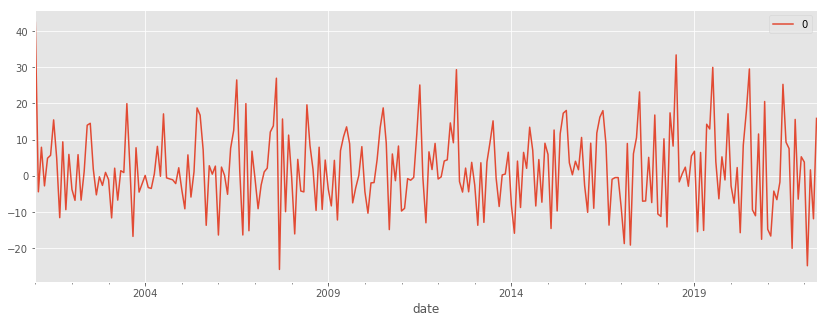

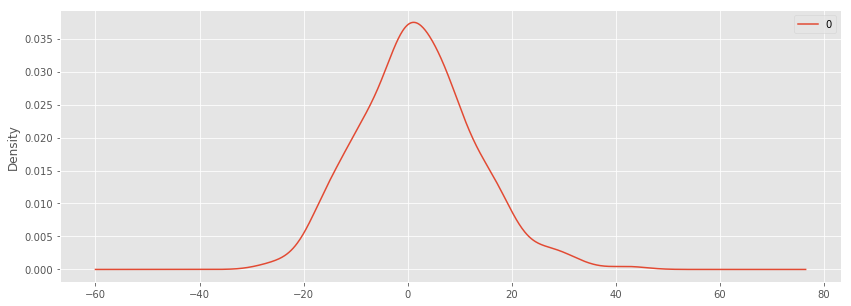

                0
count  257.000000
mean     1.862735
std     10.993555
min    -25.872981
25%     -5.265494
50%      1.176235
75%      8.373461
max     42.388663


In [127]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [128]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.092451
p-value                          0.000015
#Lags Used                      16.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [129]:
mod_arma = ARIMA(nat, order=(2,1,2))

In [130]:
res_arma = mod_arma.fit()

In [131]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -964.789
Date:                Fri, 10 Mar 2023   AIC                           1939.579
Time:                        15:33:30   BIC                           1957.305
Sample:                    01-01-2001   HQIC                          1946.708
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9808      0.009    110.191      0.000       0.963       0.998
ar.L2         -0.9924      0.009   -108.742      0.000      -1.010      -0.975
ma.L1         -0.8649      0.039    -22.132      0.0

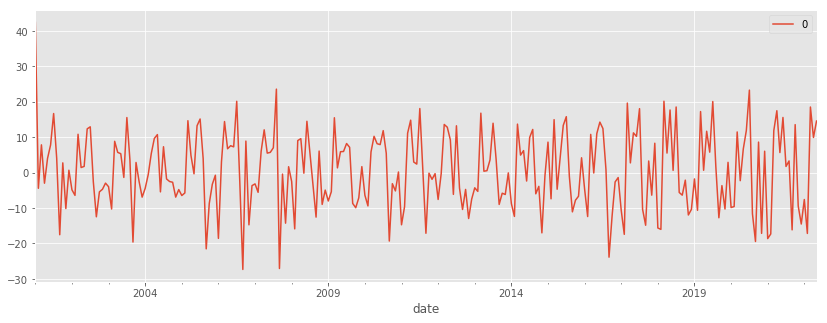

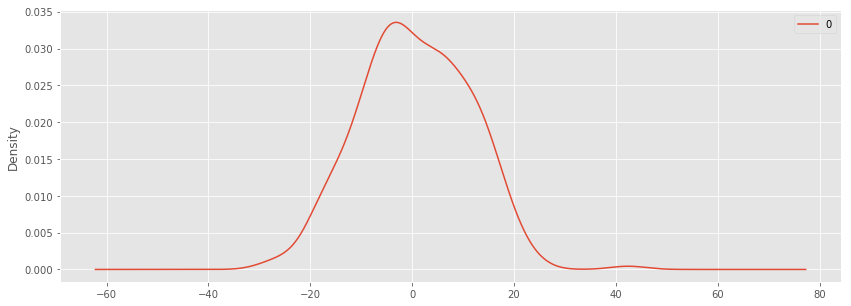

                0
count  257.000000
mean     0.530562
std     10.741612
min    -27.321070
25%     -6.467702
50%     -0.078496
75%      8.287260
max     42.388663


In [132]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [133]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.066158
p-value                          0.000016
#Lags Used                      12.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [134]:
mod_arma = ARIMA(nat, order=(2,1,5))

In [135]:
res_arma = mod_arma.fit()

In [136]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -952.503
Date:                Fri, 10 Mar 2023   AIC                           1921.007
Time:                        15:33:31   BIC                           1949.368
Sample:                    01-01-2001   HQIC                          1932.414
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9012      0.040     22.593      0.000       0.823       0.979
ar.L2         -0.8938      0.040    -22.263      0.000      -0.972      -0.815
ma.L1         -0.8348      0.067    -12.462      0.0

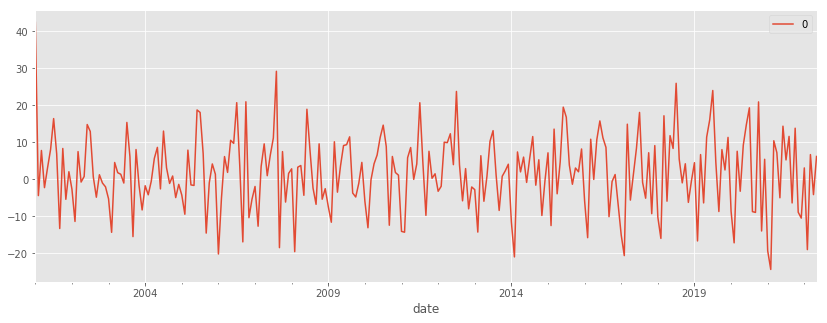

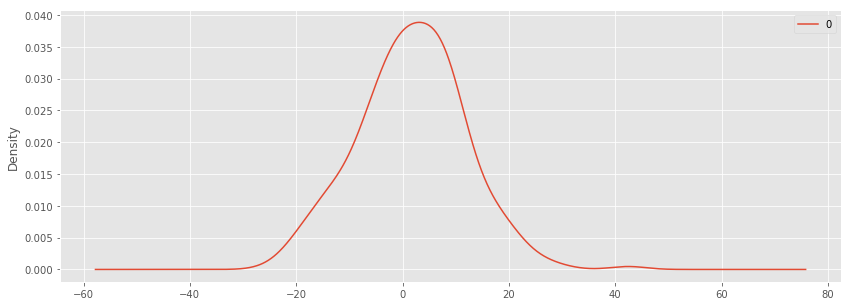

                0
count  257.000000
mean     1.682378
std     10.160581
min    -24.381424
25%     -5.013449
50%      1.806824
75%      8.050863
max     42.388663


In [137]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [138]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.098097
p-value                          0.000976
#Lags Used                      16.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [139]:
mod_arma = ARIMA(nat, order=(0,1,5))

In [140]:
res_arma = mod_arma.fit()

In [141]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -969.959
Date:                Fri, 10 Mar 2023   AIC                           1951.918
Time:                        15:33:33   BIC                           1973.189
Sample:                    01-01-2001   HQIC                          1960.473
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2023      0.059      3.458      0.001       0.088       0.317
ma.L2         -0.1699      0.060     -2.833      0.005      -0.288      -0.052
ma.L3         -0.4720      0.059     -8.039      0.0

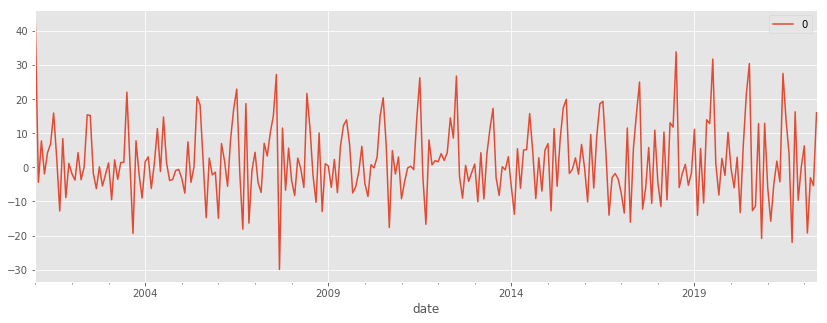

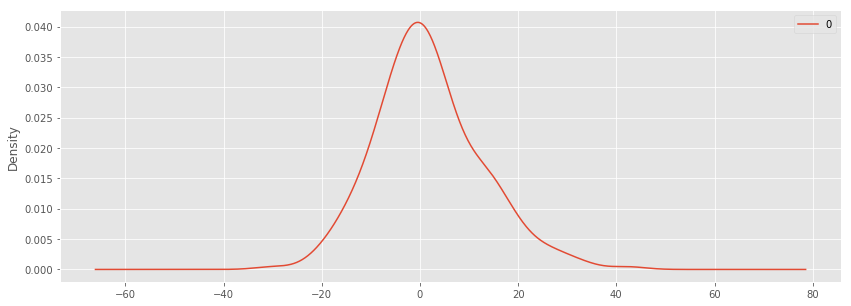

                0
count  257.000000
mean     1.732653
std     10.863238
min    -29.927965
25%     -5.518128
50%      0.716793
75%      7.680828
max     42.388663


In [142]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())



In [143]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.358205
p-value                          0.000352
#Lags Used                      16.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


## Grid search for ARIMA model

In [144]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
     # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [145]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model_aic(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
#    predictions = list()
#    for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    aic=model_fit.aic
#        yhat = model_fit.forecast()[0]
#        predictions.append(yhat)
#        history.append(test[t])
     # calculate out of sample error
#    error = mean_squared_error(test, predictions)
#    return error
    return aic

In [146]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [147]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_aic(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    aic = evaluate_arima_model_aic(dataset, order)
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [148]:
""" DID THIS TOOK FOREVER AND THE RESULT WAS 
Best ARIMANone MSE=inf
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(nat.values, p_values, d_values, q_values)"""

' DID THIS TOOK FOREVER AND THE RESULT WAS \nBest ARIMANone MSE=inf\n# evaluate parameters\np_values = [0, 1, 2, 4, 6, 8, 10]\nd_values = range(0, 5)\nq_values = range(0, 5)\nwarnings.filterwarnings("ignore")\nevaluate_models(nat.values, p_values, d_values, q_values)'

I will work on this later and try to find the best 3 values for the best model but for now...

## Split Train and test set

In [162]:
cutoff = round(nat.shape[0]*0.8)
cutoff

206

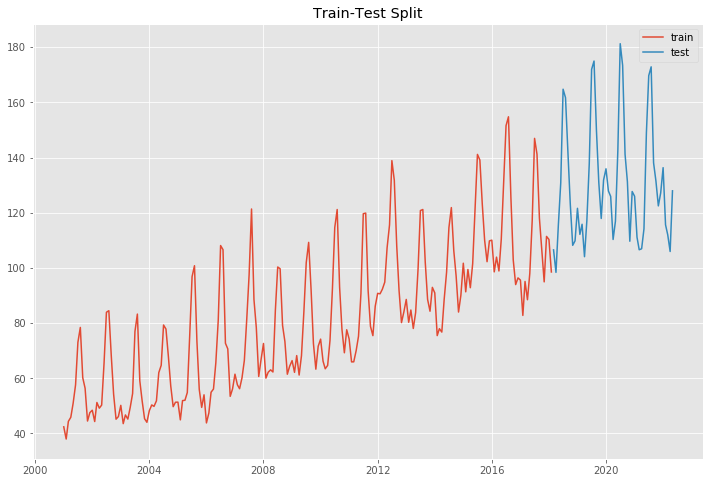

In [163]:
# Define train and test sets according to the index found above
train = nat[:cutoff]

test = nat[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [164]:
test.index[0]

Timestamp('2018-03-01 00:00:00')

In [165]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103] [104 105

## Time for an ARIMA grid search on the train

In [182]:
"""
# evaluate parameters
p_values = [1, 2, 4, 6, 8]
d_values = range(1, 5)
q_values = range(1, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)"""

'\n# evaluate parameters\np_values = [1, 2, 4, 6, 8]\nd_values = range(1, 5)\nq_values = range(1, 5)\nwarnings.filterwarnings("ignore")\nevaluate_models(train.values, p_values, d_values, q_values)'

### Best model on Train, Test and All

In [183]:
model_train = ARIMA(train, order=(8, 1, 2)).fit()
#res_arma = mod_arma
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  206
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -685.021
Date:                Fri, 10 Mar 2023   AIC                           1392.042
Time:                        15:33:42   BIC                           1428.595
Sample:                    01-01-2001   HQIC                          1406.827
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9857      0.057     17.293      0.000       0.874       1.097
ar.L2         -0.8715      0.085    -10.277      0.000      -1.038      -0.705
ar.L3          0.0066      0.101      0.065      0.9

In [184]:
y_hat_train = model_train.predict(typ='levels')
RMSE_train=np.sqrt(mean_squared_error(train, y_hat_train))
RMSE_train

7.416783723569486

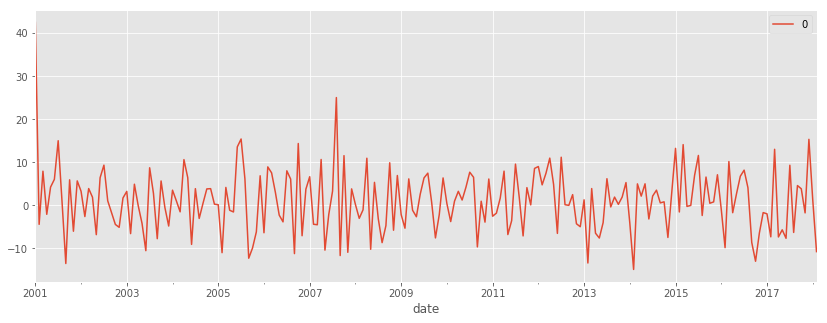

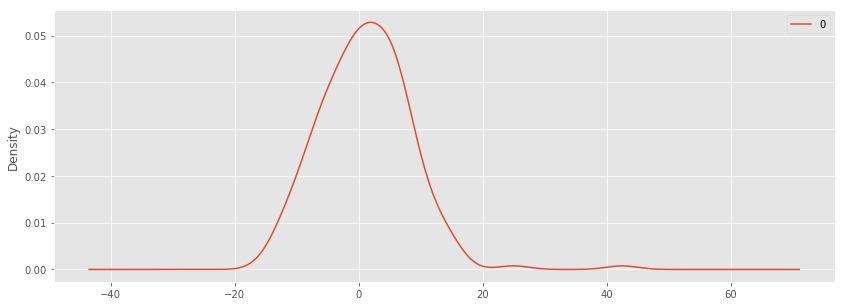

                0
count  206.000000
mean     1.024484
std      7.363581
min    -14.877304
25%     -4.087558
50%      0.939656
75%      5.978228
max     42.388663


In [185]:
# line plot of residuals
residuals = pd.DataFrame(model_train.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


In [186]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.338606
p-value                          0.000381
#Lags Used                      12.000000
Number of Observations Used    193.000000
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
dtype: float64


### Best model on test

In [187]:
model_test = ARIMA(train, order=(8, 1, 2)).fit()
#res_arma = mod_arma
print(model_test.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  206
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -685.021
Date:                Fri, 10 Mar 2023   AIC                           1392.042
Time:                        15:33:44   BIC                           1428.595
Sample:                    01-01-2001   HQIC                          1406.827
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9857      0.057     17.293      0.000       0.874       1.097
ar.L2         -0.8715      0.085    -10.277      0.000      -1.038      -0.705
ar.L3          0.0066      0.101      0.065      0.9

In [188]:
""" WILL NEED TO GET BACK TO THIS
y_hat_test = model_test.predict(typ='levels')
RMSE_test=np.sqrt(mean_squared_error(test, y_hat_test))
RMSE_test"""

" WILL NEED TO GET BACK TO THIS\ny_hat_test = model_test.predict(typ='levels')\nRMSE_test=np.sqrt(mean_squared_error(test, y_hat_test))\nRMSE_test"

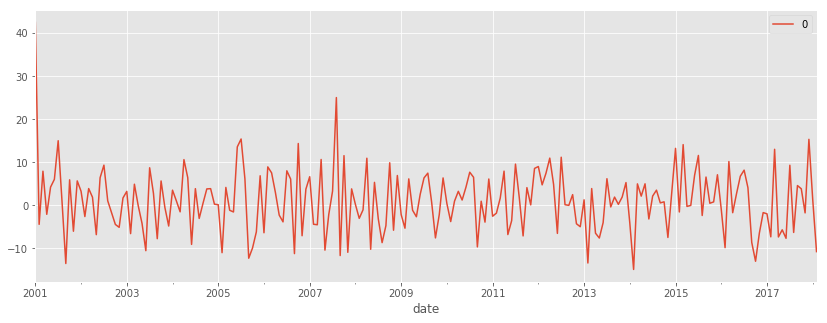

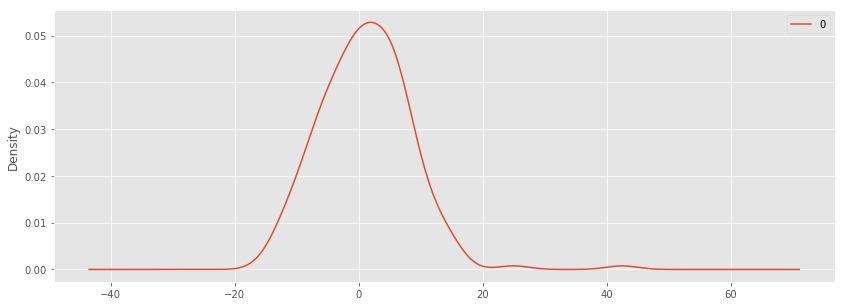

                0
count  206.000000
mean     1.024484
std      7.363581
min    -14.877304
25%     -4.087558
50%      0.939656
75%      5.978228
max     42.388663


In [189]:
# line plot of residuals
residuals = pd.DataFrame(model_test.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [190]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.338606
p-value                          0.000381
#Lags Used                      12.000000
Number of Observations Used    193.000000
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
dtype: float64


### Best model on all data

In [191]:
model_all = ARIMA(nat, order=(8, 1, 2)).fit()
#res_arma = mod_arma.fit()
print(model_all.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  257
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -868.207
Date:                Fri, 10 Mar 2023   AIC                           1758.414
Time:                        15:33:45   BIC                           1797.411
Sample:                    01-01-2001   HQIC                          1774.099
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9342      0.053     17.481      0.000       0.829       1.039
ar.L2         -0.7699      0.078     -9.813      0.000      -0.924      -0.616
ar.L3         -0.0803      0.091     -0.882      0.3

In [192]:
y_hat_all = model_all.predict(typ='levels')
RMSE_all=np.sqrt(mean_squared_error(nat, y_hat_all))
RMSE_all

7.6193634396308845

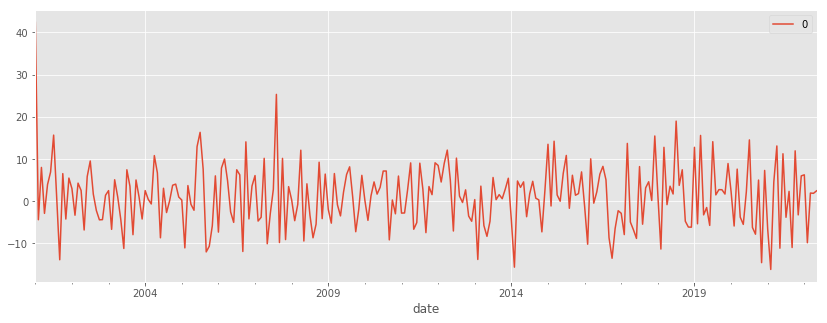

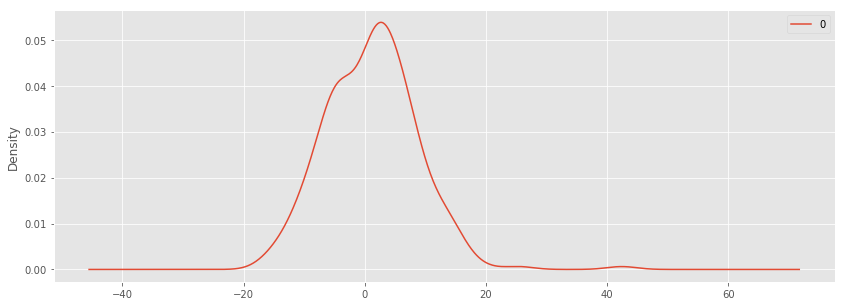

                0
count  257.000000
mean     1.125090
std      7.550543
min    -16.212996
25%     -4.403704
50%      1.495135
75%      5.977096
max     42.388663


In [193]:
# line plot of residuals
residuals = pd.DataFrame(model_all.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [194]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.198133
p-value                          0.000009
#Lags Used                      13.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


In [195]:
print(f'Model train AIC: {model_train.aic}')
print(f'Model test  AIC: {model_test.aic}')
print(f'Model all   AIC: {model_all.aic}')

Model train AIC: 1392.0418445303696
Model test  AIC: 1392.0418445303696
Model all   AIC: 1758.4143364016031


In [196]:
"""print(f'Model train RMSE: {RMSE_train}')
print(f'Model test  RMSE: {RMSE_test}')
print(f'Model all   RMSE: {RMSE_all}')"""

"print(f'Model train RMSE: {RMSE_train}')\nprint(f'Model test  RMSE: {RMSE_test}')\nprint(f'Model all   RMSE: {RMSE_all}')"

Ok. A bit crazy. The test turned out to have the best AIC but is also the one with the worst RMSE.

Let's move on to...

The search we did was based on the RMSE.
Let us see if the result is different using another function, that evaluates the model on the AIC instead.

### ARIMA search AIC

In [197]:
# using AIC as a parameter
# evaluate parameters
p_values = [1, 2, 4, 6, 8]
d_values = range(1, 5)
q_values = range(1, 5)
warnings.filterwarnings("ignore")
evaluate_models_aic(train.values, p_values, d_values, q_values)

ARIMA(1, 1, 1) AIC=1031.566
ARIMA(1, 1, 2) AIC=1011.373
ARIMA(1, 1, 3) AIC=1004.201
ARIMA(1, 1, 4) AIC=1000.708
ARIMA(1, 2, 1) AIC=1033.057
ARIMA(1, 2, 2) AIC=1031.021
ARIMA(1, 2, 3) AIC=1032.286
ARIMA(1, 2, 4) AIC=1034.119
ARIMA(1, 3, 1) AIC=1077.377
ARIMA(1, 3, 2) AIC=1081.563
ARIMA(1, 3, 3) AIC=1035.879
ARIMA(1, 3, 4) AIC=1037.232
ARIMA(1, 4, 1) AIC=1147.564
ARIMA(1, 4, 2) AIC=1082.459
ARIMA(1, 4, 3) AIC=1086.268
ARIMA(1, 4, 4) AIC=1045.521
ARIMA(2, 1, 1) AIC=995.417
ARIMA(2, 1, 2) AIC=982.370
ARIMA(2, 1, 3) AIC=977.833
ARIMA(2, 1, 4) AIC=1008.513
ARIMA(2, 2, 1) AIC=1025.855
ARIMA(2, 2, 2) AIC=991.205
ARIMA(2, 2, 3) AIC=982.508
ARIMA(2, 2, 4) AIC=1030.460
ARIMA(2, 3, 1) AIC=1074.130
ARIMA(2, 3, 2) AIC=1033.037
ARIMA(2, 3, 3) AIC=1067.921
ARIMA(2, 3, 4) AIC=1010.791
ARIMA(2, 4, 1) AIC=1137.734
ARIMA(2, 4, 2) AIC=1079.685
ARIMA(2, 4, 3) AIC=1088.722
ARIMA(2, 4, 4) AIC=1072.848
ARIMA(4, 1, 1) AIC=1021.040
ARIMA(4, 1, 2) AIC=1000.131
ARIMA(4, 1, 3) AIC=984.476
ARIMA(4, 1, 4) AIC=975.111

Slightly different result than before, but not that much different. Good.

### Let's try another grid search for ARIMA

In [210]:
"""# evaluate parameters
p_values = [8, 10, 12, 20]
d_values = [1]
q_values = [2]
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)"""

'# evaluate parameters\np_values = [8, 10, 12, 20]\nd_values = [1]\nq_values = [2]\nwarnings.filterwarnings("ignore")\nevaluate_models(train.values, p_values, d_values, q_values)'

In [211]:
model = ARIMA(train, order=(20, 1, 2)).fit()
#res_arma = mod_arma
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  206
Model:                ARIMA(20, 1, 2)   Log Likelihood                -655.046
Date:                Fri, 10 Mar 2023   AIC                           1356.092
Time:                        15:34:34   BIC                           1432.521
Sample:                    01-01-2001   HQIC                          1387.006
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1235      1.133     -0.109      0.913      -2.345       2.098
ar.L2          0.0692      1.177      0.059      0.953      -2.237       2.376
ar.L3         -0.0122      0.479     -0.026      0.9

In [212]:
y_hat_train = model.predict(typ='levels')
RMSE_train=np.sqrt(mean_squared_error(train, y_hat_train))
RMSE_train

6.5993640160393

In [213]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.198133
p-value                          0.000009
#Lags Used                      13.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


In [214]:
model = ARIMA(test, order=(20, 1, 2)).fit()
#res_arma = mod_arma
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                   51
Model:                ARIMA(20, 1, 2)   Log Likelihood                -163.739
Date:                Fri, 10 Mar 2023   AIC                            373.478
Time:                        15:34:36   BIC                            417.454
Sample:                    03-01-2018   HQIC                           390.224
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4630     13.903     -0.033      0.973     -27.712      26.786
ar.L2          0.1086      1.974      0.055      0.956      -3.760       3.977
ar.L3         -0.0187      1.382     -0.014      0.9

In [215]:
y_hat_test = model.predict(typ='levels')
RMSE_test=np.sqrt(mean_squared_error(test, y_hat_test))
RMSE_test

16.558137711237936

So, that is good but I have to start to keep in mind overfitting because that's what becomes an issue

Same gridsearch but with AIC:

In [216]:
# evaluate parameters
p_values = [8, 10, 12, 20]
d_values = [1]
q_values = [2]
warnings.filterwarnings("ignore")
evaluate_models_aic(train.values, p_values, d_values, q_values)

ARIMA(8, 1, 2) AIC=914.469
ARIMA(10, 1, 2) AIC=896.387
ARIMA(12, 1, 2) AIC=889.219
ARIMA(20, 1, 2) AIC=898.637
Best ARIMA(12, 1, 2) AIC=889.219


Interesting! Not 20 but 10. Good good.

### Grid Search SARIMAX

In [217]:
"""

# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

"""

'\n\n# Define the p, d and q parameters to take any value between 0 and 2\np = [1, 2, 4,  6, 8]\nd = range(1,3)\nq = [4]\n# Generate all different combinations of p, q and q triplets\npdq = list(itertools.product(p,d,q))\n\n# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)\npdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]\n\n'

In [218]:
"""ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue  """

"ans = []\nfor comb in pdq:\n    for combs in pdqs:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train,\n                                            order=comb,\n                                            seasonal_order=combs,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            output = mod.fit()\n            ans.append([comb, combs, output.aic])\n            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))\n        except:\n            continue  "

In [219]:
"""

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

"""

"\n\n# Find the parameters with minimal AIC value\nans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])\nans_df.loc[ans_df['aic'].idxmin()]\n\n"

The output of our code suggests that ARIMA (1, 1, 1) x (1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

It is very time consuming to run all of the options so we pickled the GridSearchCV models after we ran them and fit them.
The pickled files were also too large for the Github Repository so we had to remove them.
We show below all the code that was used for demonastrative purposes, but we comment it out and keep only the results of the search.


In [220]:
### ans_df_df.to_pickle("./resu1.pkl")  

In [221]:
### unpickled_df = pd.read_pickle("./resu1.pkl")  
### unpickled_df 

Fitting an ARIMA Time Series Model
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.

### 3 Best SARIMAX models according to first (super long) grid search

In [222]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL1 = sm.tsa.statespace.SARIMAX(nat, 
                                        order=(1, 2, 2), 
                                        seasonal_order=(2, 1, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output1 = ARIMA_MODEL1.fit()

print(output1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7380      0.081      9.139      0.000       0.580       0.896
ma.L1         -1.9980      0.560     -3.567      0.000      -3.096      -0.900
ma.L2          0.9986      0.560      1.783      0.075      -0.099       2.096
ar.S.L12      -0.2472      0.244     -1.012      0.311      -0.726       0.231
ar.S.L24      -0.5648      0.211     -2.676      0.007      -0.978      -0.151
ma.S.L12      -0.4614      0.236     -1.953      0.051      -0.924       0.002
ma.S.L24       0.2843      0.293      0.972      0.331      -0.289       0.858
ma.S.L36      -0.3918      0.179     -2.188      0.029      -0.743      -0.041
ma.S.L48       0.0242      0.096      0.251      0.802      -0.164       0.213
sigma2        28.9466     16.690      1.734      0.083      -3.766      61.659


The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature and how each one impacts the time series patterns. The  𝑃>|𝑧|
  provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

Call the .plot_diagnostics( ) method on ARIMA output below:

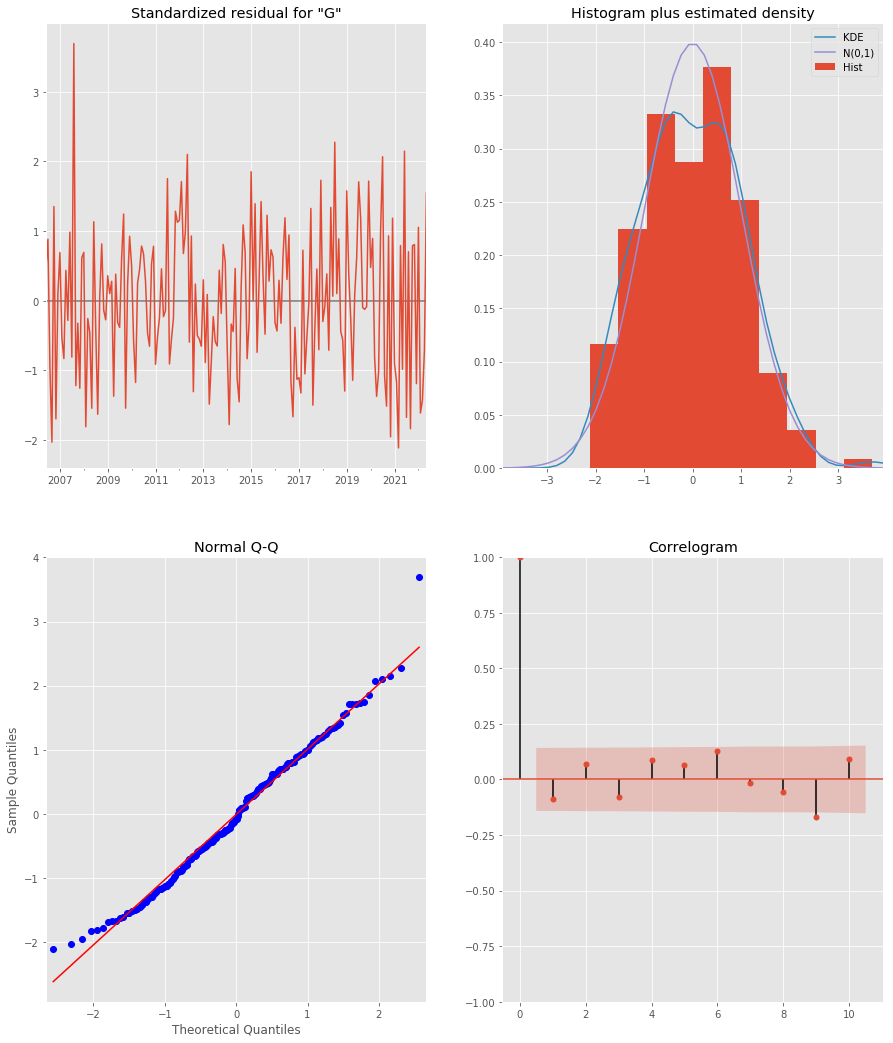

In [223]:
# Call plot_diagnostics() on the results calculated above 
output1.plot_diagnostics(figsize=(15, 18))
plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [224]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL2 = sm.tsa.statespace.SARIMAX(nat, 
                                        order=(1, 2, 3), 
                                        seasonal_order=(2, 1, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output2 = ARIMA_MODEL2.fit()

print(output2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4894      0.355      1.380      0.168      -0.206       1.184
ma.L1         -1.7529      1.364     -1.285      0.199      -4.426       0.920
ma.L2          0.7721      1.046      0.738      0.460      -1.278       2.822
ma.L3         -0.0190      0.152     -0.125      0.901      -0.318       0.280
ar.S.L12      -0.1618      0.213     -0.758      0.448      -0.580       0.257
ar.S.L24      -0.5967      0.160     -3.734      0.000      -0.910      -0.284
ma.S.L12      -0.5184      0.223     -2.328      0.020      -0.955      -0.082
ma.S.L24       0.4606      0.221      2.084      0.037       0.027       0.894
ma.S.L36      -0.4088      0.159     -2.563      0.010      -0.721      -0.096
ma.S.L48      -0.0508      0.095     -0.534      0.593      -0.237       0.136
sigma2        31.2963     47.163      0.664      0.5

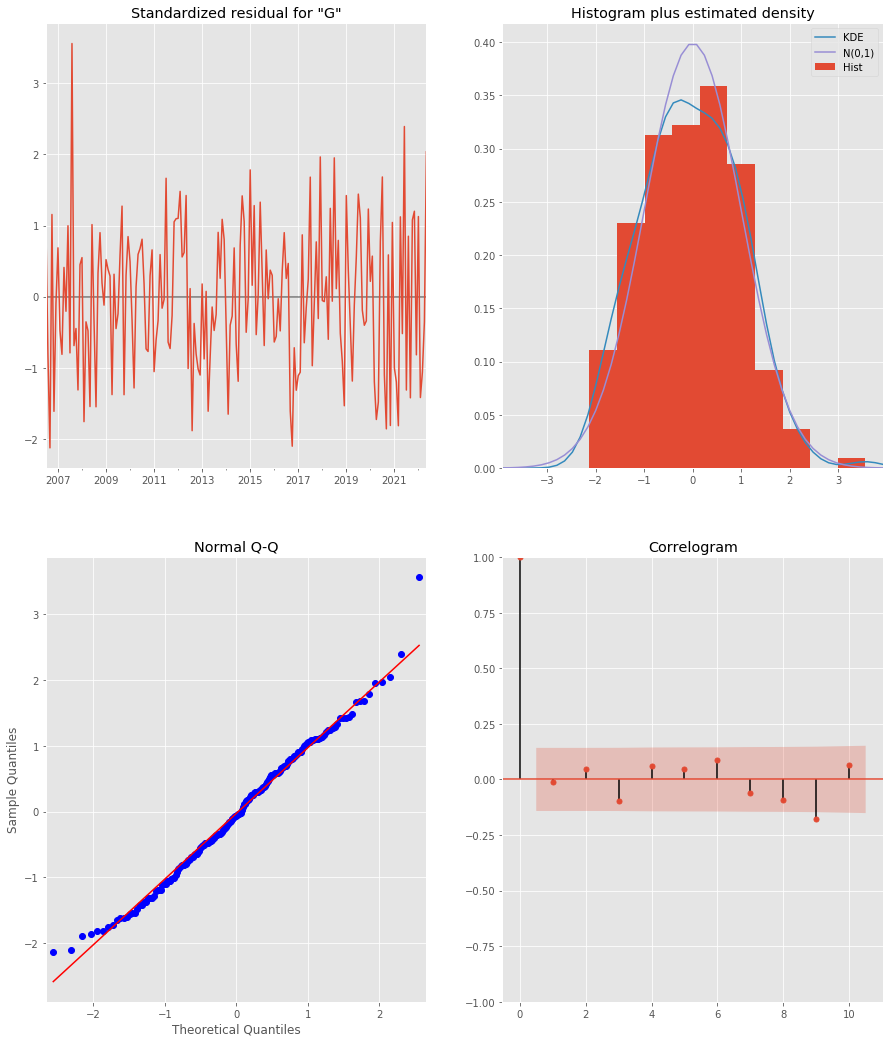

In [225]:
# Call plot_diagnostics() on the results calculated above 
output2.plot_diagnostics(figsize=(15, 18))
plt.show()

In [226]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL3 = sm.tsa.statespace.SARIMAX(nat, 
                                        order=(1, 2, 4), 
                                        seasonal_order=(1, 2, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output3 = ARIMA_MODEL3.fit()

print(output3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0354      0.523     -0.068      0.946      -1.060       0.989
ma.L1         -1.2555      1.156     -1.086      0.277      -3.521       1.010
ma.L2          0.2290      0.757      0.302      0.762      -1.255       1.713
ma.L3         -0.1320      0.167     -0.791      0.429      -0.459       0.195
ma.L4          0.1574      0.202      0.778      0.437      -0.239       0.554
ar.S.L12      -0.8020      0.085     -9.423      0.000      -0.969      -0.635
ma.S.L12      -0.7802      2.661     -0.293      0.769      -5.996       4.436
ma.S.L24      -1.5153      0.691     -2.194      0.028      -2.869      -0.162
ma.S.L36       1.2346      3.645      0.339      0.735      -5.910       8.379
ma.S.L48       0.0826      0.398      0.208      0.836      -0.697       0.862
sigma2        15.1478     44.372      0.341      0.7

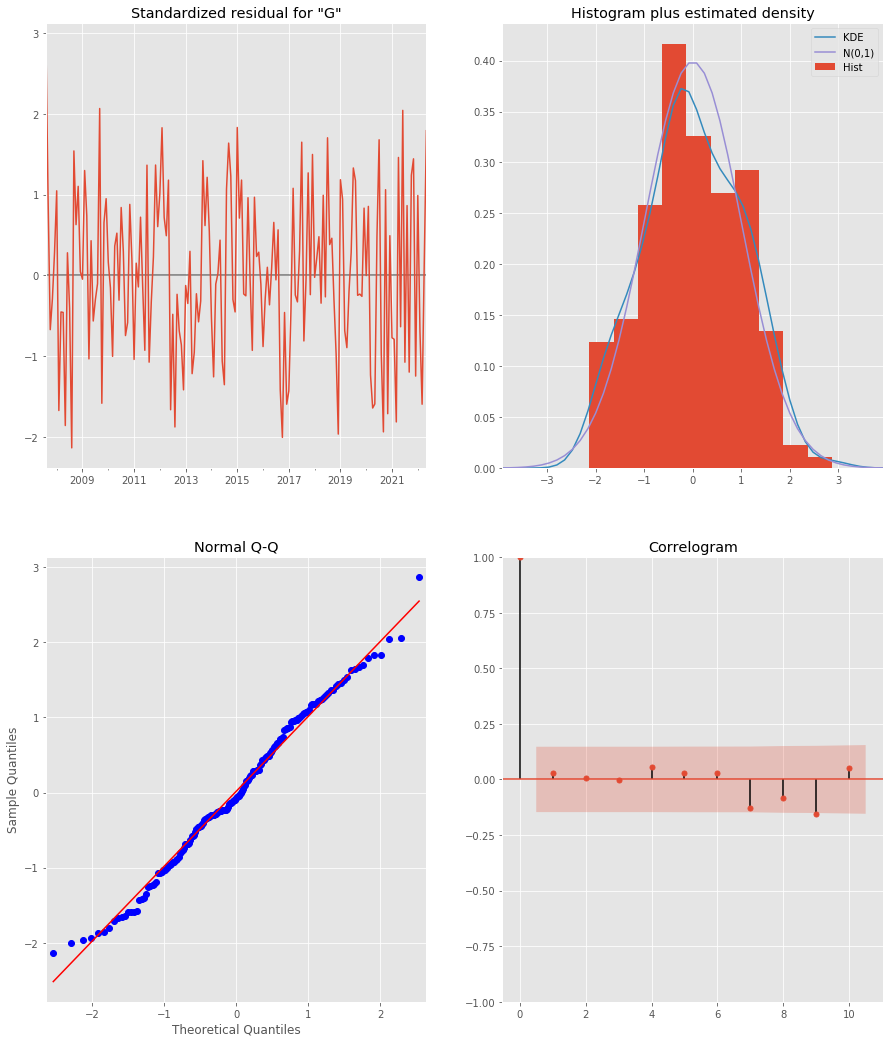

In [227]:
# Call plot_diagnostics() on the results calculated above 
output3.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

Do both one-step-ahead and dynamic forecasting, maybe with top 3 performing models.
I feel like we should do this on the test set, instead of the train?

### GO BACK TO UNDERSTAND HOW TO USE TRAIN AND VALIDATION BUT FOR NOW...

### One step Ahead Forecasting

In [228]:
pred1 = output1.get_prediction(start=pd.to_datetime('2018-03-01'), dynamic=False)
pred_conf = pred1.conf_int()

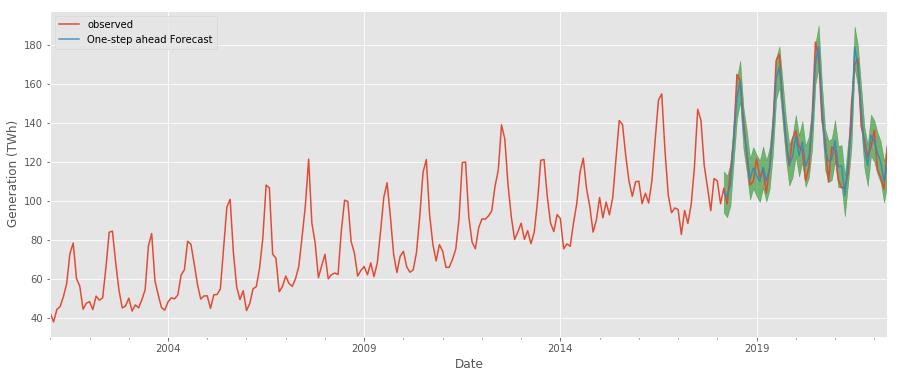

In [229]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [230]:
# Get the real and predicted values
nat_forecasted = pred1.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 41.6


#### Second Model

In [231]:
pred2 = output2.get_prediction(start=pd.to_datetime('2018-03-01'), dynamic=False)
pred_conf = pred2.conf_int()

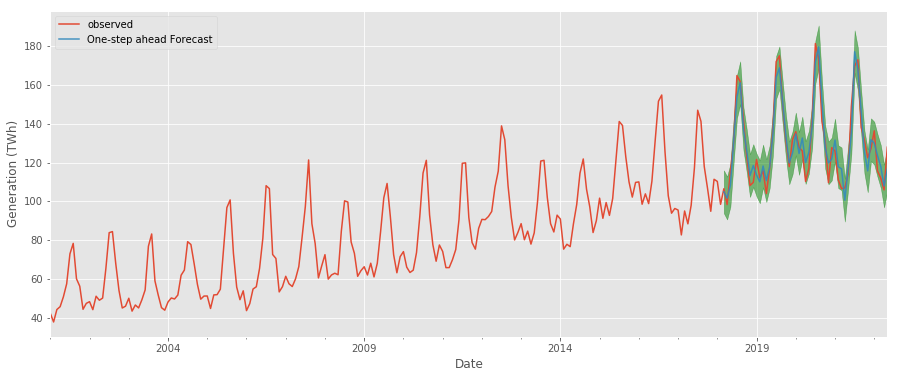

In [232]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [233]:
# Get the real and predicted values
nat_forecasted = pred2.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 42.24


#### Third model

In [234]:
pred3 = output3.get_prediction(start=pd.to_datetime('2018-03-01'), dynamic=False)
pred_conf = pred3.conf_int()

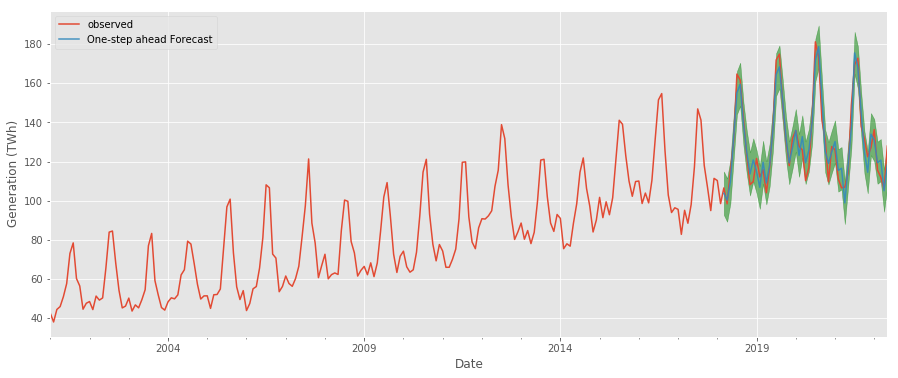

In [235]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [236]:
# Get the real and predicted values
nat_forecasted = pred3.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 38.35


Third model wins. Nice.

### Dynamic Forecasting

In [245]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic1 = output1.get_prediction(pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic1.conf_int()

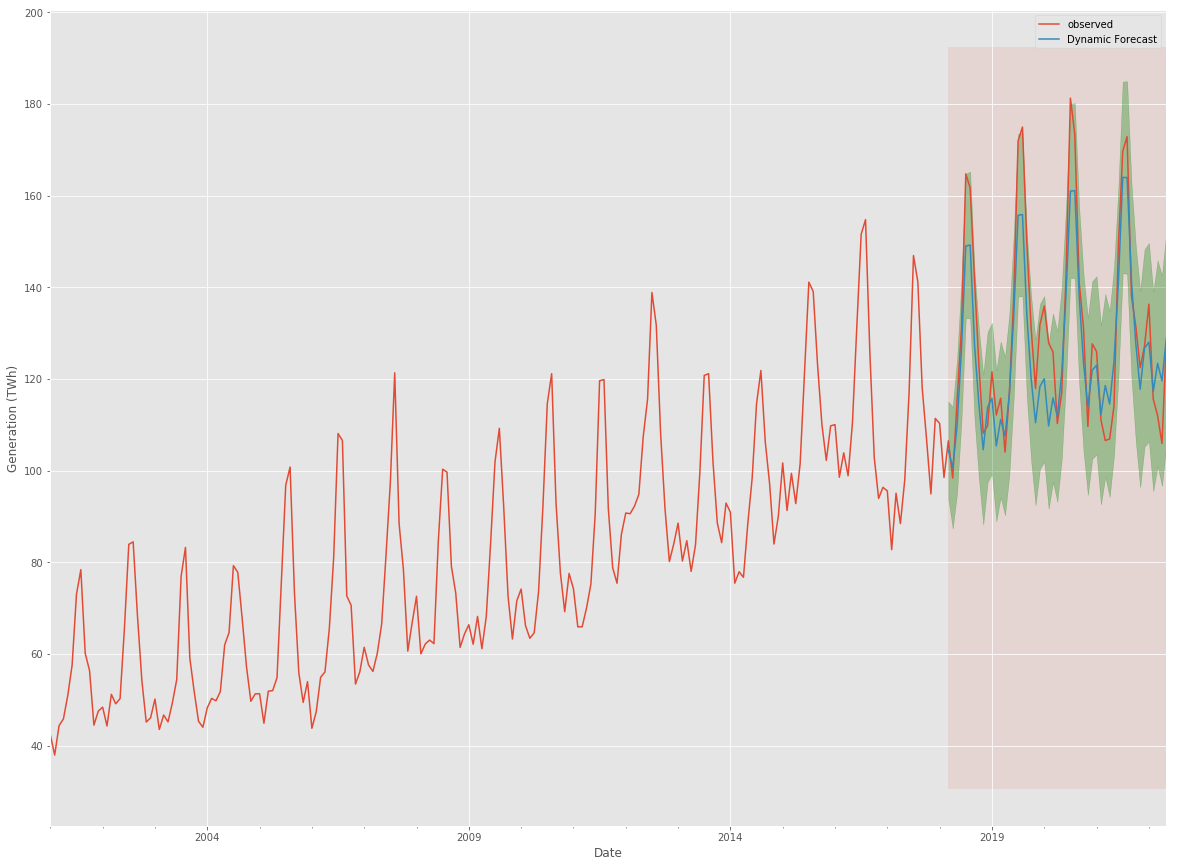

In [246]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic1.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [247]:
# Get the real and predicted values
nat_forecasted = pred_dynamic1.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 87.17


Second SARIMAX

In [248]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic2 = output2.get_prediction(pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic2.conf_int()

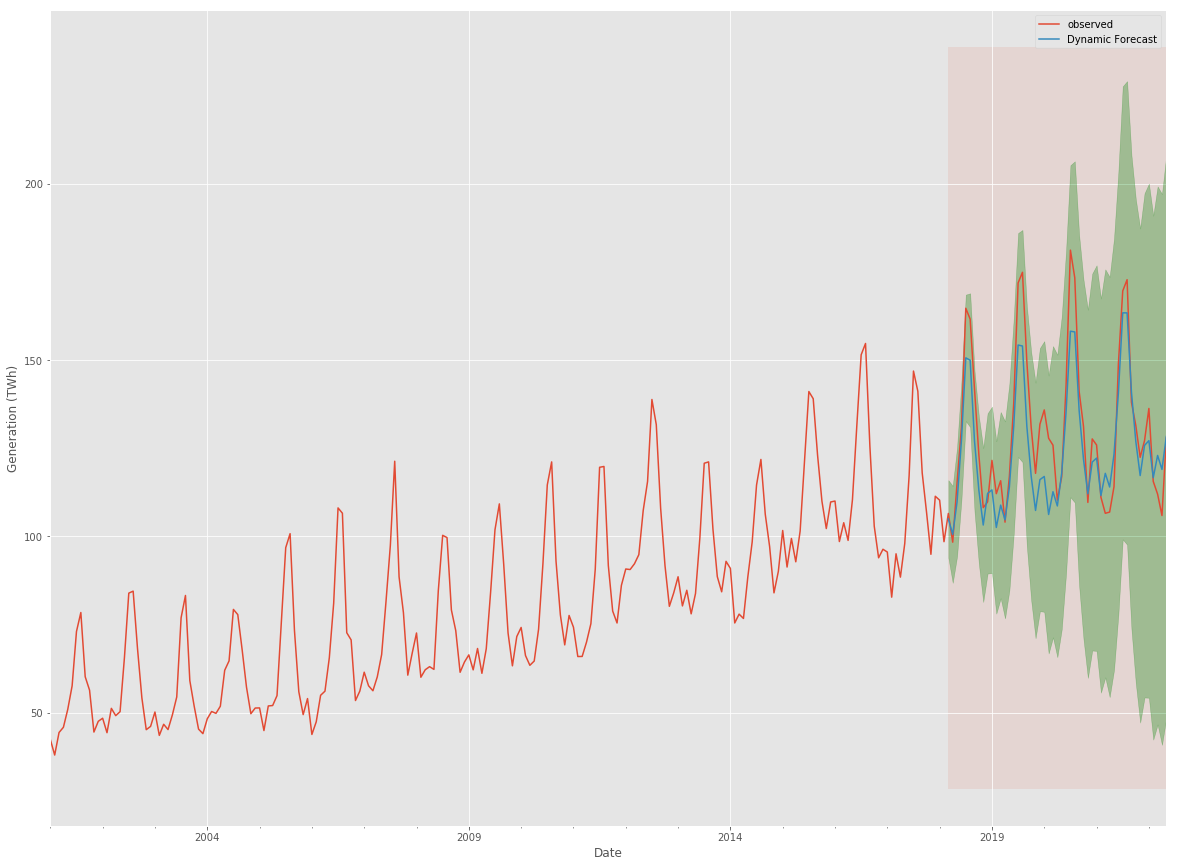

In [251]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic2.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [249]:
# Get the real and predicted values
nat_forecasted = pred_dynamic2.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 108.33


SARIMAX 3

In [252]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic3 = output3.get_prediction(pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic3.conf_int()

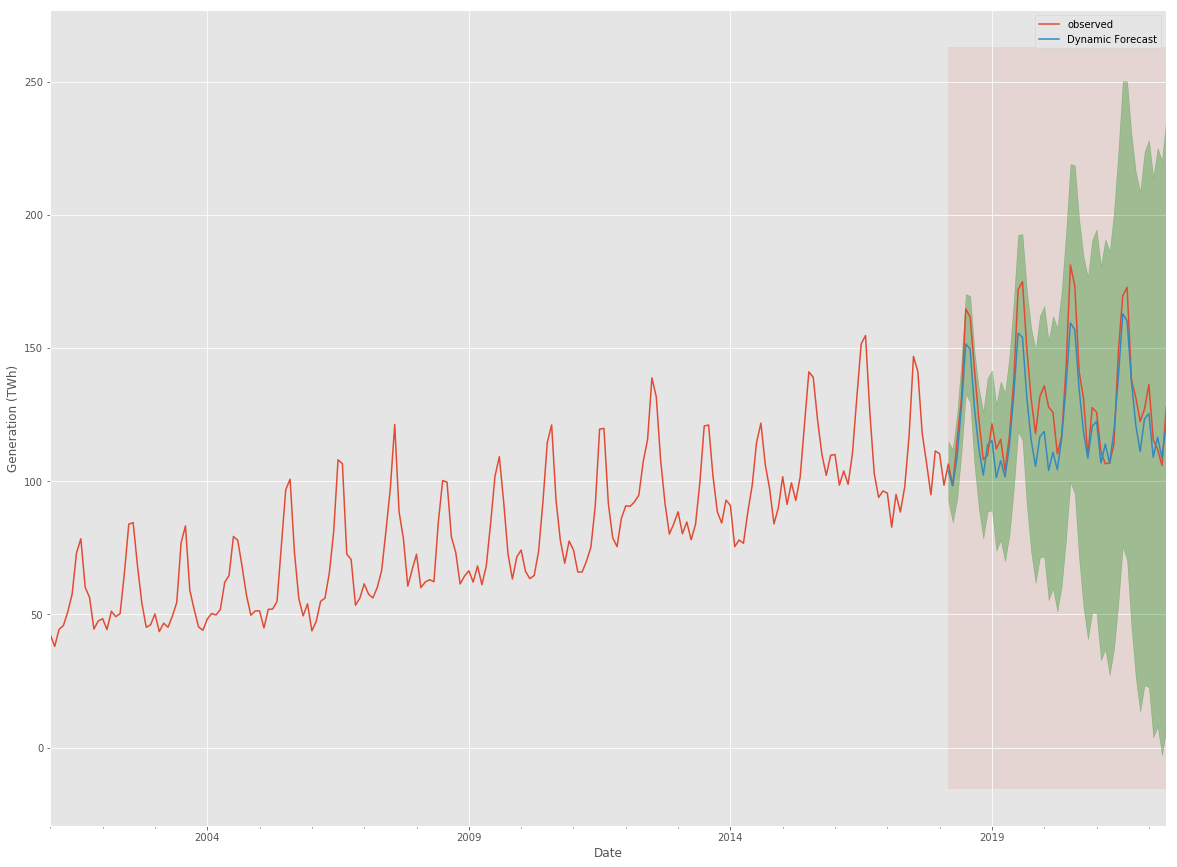

In [253]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic3.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [254]:
# Get the real and predicted values
nat_forecasted = pred_dynamic3.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 112.41


Or figure out what Greg was doing with the validation set.

in any case learning how to do
## Forecasting

### Second Grid Search SARIMAX

In [287]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 4, 8]
d = range(1,3)
q = [4]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [288]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (1, 1, 4) x (1, 1, 4, 12): AIC Calculated=882.4354461946175
ARIMA (1, 1, 4) x (1, 2, 4, 12): AIC Calculated=22.0
ARIMA (1, 1, 4) x (4, 1, 4, 12): AIC Calculated=877.596320806493
ARIMA (1, 1, 4) x (4, 2, 4, 12): AIC Calculated=8552.920899264343
ARIMA (1, 1, 4) x (8, 1, 4, 12): AIC Calculated=609.7953450908863
ARIMA (1, 1, 4) x (8, 2, 4, 12): AIC Calculated=36.0
ARIMA (1, 2, 4) x (1, 1, 4, 12): AIC Calculated=907.0012791889611
ARIMA (1, 2, 4) x (1, 2, 4, 12): AIC Calculated=22.0
ARIMA (1, 2, 4) x (4, 1, 4, 12): AIC Calculated=1037.992289349588
ARIMA (1, 2, 4) x (4, 2, 4, 12): AIC Calculated=28.0
ARIMA (1, 2, 4) x (8, 1, 4, 12): AIC Calculated=36.0
ARIMA (1, 2, 4) x (8, 2, 4, 12): AIC Calculated=36.0
ARIMA (4, 1, 4) x (1, 1, 4, 12): AIC Calculated=885.7399288990923
ARIMA (4, 1, 4) x (1, 2, 4, 12): AIC Calculated=28.0
ARIMA (4, 1, 4) x (4, 1, 4, 12): AIC Calculated=881.2619500143466
ARIMA (4, 1, 4) x (4, 2, 4, 12): AIC Calculated=34.0
ARIMA (4, 1, 4) x (8, 1, 4, 12): AIC Calculated=5

In [289]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 4)
pdqs    (1, 2, 4, 12)
aic                22
Name: 1, dtype: object

In [291]:
ans_df.to_pickle("./resgrid.pkl")

In [292]:
unpickled_df = pd.read_pickle("./resgrid.pkl")  
unpickled_df

pdq           pdqs           aic
0   (1, 1, 4)  (1, 1, 4, 12)    882.435446
1   (1, 1, 4)  (1, 2, 4, 12)     22.000000
2   (1, 1, 4)  (4, 1, 4, 12)    877.596321
3   (1, 1, 4)  (4, 2, 4, 12)   8552.920899
4   (1, 1, 4)  (8, 1, 4, 12)    609.795345
5   (1, 1, 4)  (8, 2, 4, 12)     36.000000
6   (1, 2, 4)  (1, 1, 4, 12)    907.001279
7   (1, 2, 4)  (1, 2, 4, 12)     22.000000
8   (1, 2, 4)  (4, 1, 4, 12)   1037.992289
9   (1, 2, 4)  (4, 2, 4, 12)     28.000000
10  (1, 2, 4)  (8, 1, 4, 12)     36.000000
11  (1, 2, 4)  (8, 2, 4, 12)     36.000000
12  (4, 1, 4)  (1, 1, 4, 12)    885.739929
13  (4, 1, 4)  (1, 2, 4, 12)     28.000000
14  (4, 1, 4)  (4, 1, 4, 12)    881.261950
15  (4, 1, 4)  (4, 2, 4, 12)     34.000000
16  (4, 1, 4)  (8, 1, 4, 12)    581.546232
17  (4, 1, 4)  (8, 2, 4, 12)     42.000000
18  (4, 2, 4)  (1, 1, 4, 12)    405.083532
19  (4, 2, 4)  (1, 2, 4, 12)     28.000000
20  (4, 2, 4)  (4, 1, 4, 12)    345.678697
21  (4, 2, 4)  (4, 2, 4, 12)     34.000000
22  (4, 2, 4)  (8, 1, 4, 12)     42.000000
23  (4, 2, 4)  (8, 2, 4, 12)     42.000000
24  (8, 1, 4)  (1, 1, 4, 12)   5520.296929
25  (8, 1, 4)  (1, 2, 4, 12)           NaN
26  (8, 1, 4)  (4, 1, 4, 12)           NaN
27  (8, 1, 4)  (4, 2, 4, 12)   7644.564515
28  (8, 1, 4)  (8, 1, 4, 12)   2687.119856
29  (8, 1, 4)  (8, 2, 4, 12)           NaN
30  (8, 2, 4)  (1, 1, 4, 12)           NaN
31  (8, 2, 4)  (1, 2, 4, 12)  10090.173882
32  (8, 2, 4)  (4, 1, 4, 12)           NaN
33  (8, 2, 4)  (4, 2, 4, 12)  11058.933206
34  (8, 2, 4)  (8, 1, 4, 12)           NaN
35  (8, 2, 4)  (8, 2, 4, 12)   1859.516277

In [294]:
#Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4, 6, 8]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [295]:
ans2 = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (1, 1, 1) x (1, 1, 1, 12): AIC Calculated=1108.463139870541
ARIMA (1, 1, 1) x (1, 1, 2, 12): AIC Calculated=1040.0785883580184
ARIMA (1, 1, 1) x (1, 2, 1, 12): AIC Calculated=1113.72364436206
ARIMA (1, 1, 1) x (1, 2, 2, 12): AIC Calculated=1003.2306087074321
ARIMA (1, 1, 1) x (2, 1, 1, 12): AIC Calculated=1046.0445173285793
ARIMA (1, 1, 1) x (2, 1, 2, 12): AIC Calculated=1041.654714802604
ARIMA (1, 1, 1) x (2, 2, 1, 12): AIC Calculated=1037.4473847647328
ARIMA (1, 1, 1) x (2, 2, 2, 12): AIC Calculated=1024.912736159065
ARIMA (1, 1, 1) x (4, 1, 1, 12): AIC Calculated=896.6639121426927
ARIMA (1, 1, 1) x (4, 1, 2, 12): AIC Calculated=898.2974078753425
ARIMA (1, 1, 1) x (4, 2, 1, 12): AIC Calculated=868.8805445129191
ARIMA (1, 1, 1) x (4, 2, 2, 12): AIC Calculated=870.1883121147057
ARIMA (1, 1, 1) x (6, 1, 1, 12): AIC Calculated=731.6988571978638
ARIMA (1, 1, 1) x (6, 1, 2, 12): AIC Calculated=733.6128245952133
ARIMA (1, 1, 1) x (6, 2, 1, 12): AIC Calculated=678.0695499005645
ARIMA (

ARIMA (2, 2, 1) x (2, 1, 1, 12): AIC Calculated=1051.1829044846158
ARIMA (2, 2, 1) x (2, 1, 2, 12): AIC Calculated=1052.776845570489
ARIMA (2, 2, 1) x (2, 2, 1, 12): AIC Calculated=1033.930280032848
ARIMA (2, 2, 1) x (2, 2, 2, 12): AIC Calculated=1035.9293526124095
ARIMA (2, 2, 1) x (4, 1, 1, 12): AIC Calculated=894.8379351645636
ARIMA (2, 2, 1) x (4, 1, 2, 12): AIC Calculated=896.4227845951759
ARIMA (2, 2, 1) x (4, 2, 1, 12): AIC Calculated=865.75894701126
ARIMA (2, 2, 1) x (4, 2, 2, 12): AIC Calculated=867.7521751397327
ARIMA (2, 2, 1) x (6, 1, 1, 12): AIC Calculated=727.9026613457196
ARIMA (2, 2, 1) x (6, 1, 2, 12): AIC Calculated=730.9106772313876
ARIMA (2, 2, 1) x (6, 2, 1, 12): AIC Calculated=678.0501186684126
ARIMA (2, 2, 1) x (6, 2, 2, 12): AIC Calculated=677.2576393042366
ARIMA (2, 2, 1) x (8, 1, 1, 12): AIC Calculated=590.361849844668
ARIMA (2, 2, 1) x (8, 1, 2, 12): AIC Calculated=590.7034712102999
ARIMA (2, 2, 1) x (8, 2, 1, 12): AIC Calculated=537.9161615968142
ARIMA (2, 2

ARIMA (6, 1, 1) x (4, 1, 1, 12): AIC Calculated=868.9159861522617
ARIMA (6, 1, 1) x (4, 1, 2, 12): AIC Calculated=872.0424055608185
ARIMA (6, 1, 1) x (4, 2, 1, 12): AIC Calculated=833.068816644831
ARIMA (6, 1, 1) x (4, 2, 2, 12): AIC Calculated=835.0688692429014
ARIMA (6, 1, 1) x (6, 1, 1, 12): AIC Calculated=705.2536485658584
ARIMA (6, 1, 1) x (6, 1, 2, 12): AIC Calculated=707.2097083625317
ARIMA (6, 1, 1) x (6, 2, 1, 12): AIC Calculated=653.7928199789874
ARIMA (6, 1, 1) x (6, 2, 2, 12): AIC Calculated=654.043808870024
ARIMA (6, 1, 1) x (8, 1, 1, 12): AIC Calculated=571.5559804414806
ARIMA (6, 1, 1) x (8, 1, 2, 12): AIC Calculated=570.9980949677341
ARIMA (6, 1, 1) x (8, 2, 1, 12): AIC Calculated=515.4266468384376
ARIMA (6, 1, 1) x (8, 2, 2, 12): AIC Calculated=515.5804596157367
ARIMA (6, 1, 2) x (1, 1, 1, 12): AIC Calculated=1094.0396224650076
ARIMA (6, 1, 2) x (1, 1, 2, 12): AIC Calculated=1042.2402746154064
ARIMA (6, 1, 2) x (1, 2, 1, 12): AIC Calculated=1091.1279532759468
ARIMA (6,

ARIMA (8, 2, 1) x (6, 1, 1, 12): AIC Calculated=692.93343040544
ARIMA (8, 2, 1) x (6, 1, 2, 12): AIC Calculated=693.9252401677484
ARIMA (8, 2, 1) x (6, 2, 1, 12): AIC Calculated=640.2223251249753
ARIMA (8, 2, 1) x (6, 2, 2, 12): AIC Calculated=641.6248089437381
ARIMA (8, 2, 1) x (8, 1, 1, 12): AIC Calculated=552.4254785954158
ARIMA (8, 2, 1) x (8, 1, 2, 12): AIC Calculated=554.0428000004102
ARIMA (8, 2, 1) x (8, 2, 1, 12): AIC Calculated=500.73384998958005
ARIMA (8, 2, 1) x (8, 2, 2, 12): AIC Calculated=498.05840913656283
ARIMA (8, 2, 2) x (1, 1, 1, 12): AIC Calculated=1091.673095989228
ARIMA (8, 2, 2) x (1, 1, 2, 12): AIC Calculated=1048.9976984648324
ARIMA (8, 2, 2) x (1, 2, 1, 12): AIC Calculated=1081.9934006364838
ARIMA (8, 2, 2) x (1, 2, 2, 12): AIC Calculated=1013.7020037578037
ARIMA (8, 2, 2) x (2, 1, 1, 12): AIC Calculated=1019.7831945894652
ARIMA (8, 2, 2) x (2, 1, 2, 12): AIC Calculated=1017.9959372109299
ARIMA (8, 2, 2) x (2, 2, 1, 12): AIC Calculated=991.3111220197726
ARIMA

In [306]:
# Find the parameters with minimal AIC value
ans2_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans2_df.loc[ans2_df['aic'].idxmin()]

pdq         (1, 1, 4)
pdqs    (1, 2, 4, 12)
aic                22
Name: 1, dtype: object

ans2_df

In [303]:
ans2_df

pdq           pdqs          aic
0    (1, 1, 4)  (1, 1, 4, 12)   882.435446
1    (1, 1, 4)  (1, 2, 4, 12)    22.000000
2    (1, 1, 4)  (4, 1, 4, 12)   877.596321
3    (1, 1, 4)  (4, 2, 4, 12)  8552.920899
4    (1, 1, 4)  (8, 1, 4, 12)   609.795345
..         ...            ...          ...
431  (8, 2, 2)  (6, 2, 2, 12)   643.651133
432  (8, 2, 2)  (8, 1, 1, 12)   555.769809
433  (8, 2, 2)  (8, 1, 2, 12)   555.484232
434  (8, 2, 2)  (8, 2, 1, 12)   498.918120
435  (8, 2, 2)  (8, 2, 2, 12)   499.711007

[436 rows x 3 columns]

In [304]:
ans2_df.to_pickle("./resgrid2.pkl")

In [305]:
unpickled2_df = pd.read_pickle("./resgrid2.pkl")  
unpickled2_df

pdq           pdqs          aic
0    (1, 1, 4)  (1, 1, 4, 12)   882.435446
1    (1, 1, 4)  (1, 2, 4, 12)    22.000000
2    (1, 1, 4)  (4, 1, 4, 12)   877.596321
3    (1, 1, 4)  (4, 2, 4, 12)  8552.920899
4    (1, 1, 4)  (8, 1, 4, 12)   609.795345
..         ...            ...          ...
431  (8, 2, 2)  (6, 2, 2, 12)   643.651133
432  (8, 2, 2)  (8, 1, 1, 12)   555.769809
433  (8, 2, 2)  (8, 1, 2, 12)   555.484232
434  (8, 2, 2)  (8, 2, 1, 12)   498.918120
435  (8, 2, 2)  (8, 2, 2, 12)   499.711007

[436 rows x 3 columns]

In [307]:
unpickled2_df.isna().sum()

pdq     0
pdqs    0
aic     6
dtype: int64

In [311]:
ans2_df['aic']

0       882.435446
1        22.000000
2       877.596321
3      8552.920899
4       609.795345
          ...     
431     643.651133
432     555.769809
433     555.484232
434     498.918120
435     499.711007
Name: aic, Length: 436, dtype: float64